<font size="5">GenRA-py LTEA Workflow</font>

Chm vs bio descriptors analysis
This is a effort to:
1. define the data sets(chemicals,their descriptors, and toxicities)
2. perform global analysis on various descriptor combinations
    1. number of chemicals in each global data set
        1.tox
        2. total chemicals
        3. n_pox
        4. n_neg
    2. Determine global performance for each data set. Which descriptor performed the best. 
3. perform local analysis for each data set and detereming which dad set performed best. 

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline

import pandas as pd
import numpy as np
import pylab as pl
import scipy as sp
import sys
import os 
import seaborn as sns
from scipy import stats
from box import Box
import warnings

from IPython.core.display import display, HTML

warnings.simplefilter('ignore')

TOP = "/Users/tia/Desktop/genra-py_usecase/" #"/share/home3/ttate/ltea_R/genra-py_usecase"
#TOP = "/". join(os.getcwd().split('/')["-2"])+'/'
LIB = TOP+'src'
if not LIB in sys.path:
    sys.path.insert(0, LIB)
    
os.environ['genra-py']=LIB

DATA_DIR = TOP +'/data/'
FIG_DIR = TOP +'/figs/'

Populating the interactive namespace from numpy and matplotlib


In [2]:
D1 = TOP+'/data/'

In [ ]:
CHM1 = pd.read_csv(D1+'S7-chem.tsv', sep='\t')
#morgan, torsion, and toxprints 
TOX1 = pd.read_csv(D1+'S1-tox.tsv', sep='\t')
#toxref db v2 query 4.2020
BIO1 = pd.read_csv(D1+'S2-bio.tsv', sep='\t') 
#ltea group gene and assay level bio data
CLS1 = pd.read_csv(D1+'S3-clust.tsv', sep='\t')
#previously generated clusters from Shah 2016 GenRA manuscript

<font size="4">CHM1 Data</font>

Chemical Data 

    -Chemical names:DTXSID, preferred_name
    -toxprints: toxp_*
    -morgan fps: mrgn_*
    -topological torsion fps: tptr_*

There are some blank spaces which we will replace with na and remove

In [4]:
CHM1.shape

(1022, 4827)

In [4]:
CHM1 = CHM1.replace(['-'], np.nan)
CHM1.isnull().values.any()
CHM1 = CHM1.dropna()
CHM1.shape

(1017, 4827)

In [5]:
#set([i[0] for i in CHM1.columns.str.split('_')])
CHM1_nm = CHM1[['DTXSID', 'PREFERRED_NAME']].set_index('DTXSID')
X = CHM1 = CHM1.drop(['PREFERRED_NAME'], axis=1).set_index('DTXSID')

CHM11 = Box()
for i in set([i[0] for i in X.columns.str.split('_') ]):
    CHM11[i] =  X[X.columns[X.columns.str.match(i)]]

In [6]:
CHM11.mrgn.shape

(1017, 2048)

In [7]:
CHM11.toxp.shape

(1017, 729)

In [8]:
CHM11.tptr.shape

(1017, 2048)

<font size ="4">BIO1 Data</font>

Biological data

Organizing Biological data

    -gene_* gene level bio data 
    -assay_* assay level bio data

In [9]:
BIO1 = BIO1.rename(columns = {'dsstox_substance_id':'DTXSID'})
BIO1.isnull().values.any()
BIO1.isnull().sum().sum()

0

In [10]:
BIO1 = BIO1.drop(['chnm', 'casn'], axis = 1).set_index('DTXSID')
#set([i[0] for i in BIO1.columns.str.split('_')])

BIO11 = Box()
for i in set([i[0] for i in BIO1.columns.str.split('_')]):
    BIO11[i]=BIO1[BIO1.columns[BIO1.columns.str.match(i)]]

In [12]:
BIO11.gene.shape

(1065, 95)

In [13]:
BIO11.assay.shape

(1065, 189)

<font size ="4">TOX1 Data</font> 

Toxicity Data 

All pos and negative endpoints in Toxrefdbv2.0

In [175]:
TOX1.shape

(935, 920)

In [174]:
TOX1.head()

,acu_calcium,acu_clinical_signs,acu_intestine_large,acu_intestine_small,acu_lung,acu_mortality,acu_stomach,chr_5._nucleotidase,chr_.other.,chr_adrenal_gland,...,sub_ureter,sub_urethra,sub_uric_acid,sub_urinary_bladder,sub_urobilinogen,sub_uterus,sub_vagina,sub_volume,sub_water_consumption,sub_zinc
DTXSID,,,,,,,,,,,,,,,,,,,,,
DTXSID0020151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DTXSID0020232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DTXSID0020311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DTXSID0020315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DTXSID0020319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [178]:
TOX1 = TOX1.rename(columns = {'dsstox_substance_id':'DTXSID'})
TOX1 = TOX1.drop(['preferred_name'], axis=1).set_index('DTXSID')
#set([i[0] for i in TOX1.columns.str.split('_')])
TOX11 = Box()
for i in set([i[0] for i in TOX1.columns.str.split('_')]):
    TOX11[i] = TOX1[TOX1.columns[TOX1.columns.str.match(i)]]

In [122]:
list(TOX11.keys())

['dev', 'chr', 'mgr', 'acu', 'oth', 'sac', 'neu', 'rep', 'dnt', 'sub']

In [17]:
TOX1.columns[TOX1.columns.str.find('_liver')>-1]

Index(['chr_liver', 'dev_liver', 'dnt_liver', 'mgr_liver', 'neu_liver',
       'oth_liver', 'rep_liver', 'sac_liver', 'sub_liver'],
      dtype='object')

In [18]:
#liver = TOX1.filter(regex='_liver$')
#liver.shape

In [19]:
#liver.isnull().values.any()
#liver.isnull().sum().sum()

<font size ="3">For each descriptor and each liver endpoint, now we want to know the pos and neg effects</font>

In [244]:
#pos and neg effects
Chm = list(CHM11.keys())
#Bio = list(BIO11.keys())

for Effect in TOX1.columns:#TOX1.columns:
    #print(Effect)
    Yf = TOX1[Effect].dropna()
    Yf[Yf>0]=1
    Yb = Yf.copy()
    Yb = Yb.astype(np.int)

   
    
    for C in Chm:
        INT=CHM11[C].index.intersection(Yb.index)
        X = CHM11[C].loc[INT].dropna()
        Yb=Yb.loc[X.index]
        Yf=Yf.loc[X.index]
        if X.shape[0]>20: 
            print(Effect,C,X.shape,
            Yb.value_counts())
        
            #print (Yb.value_counts())
            
            
    #for B in Bio:
     #   INT1=BIO11[B].index.intersection(Yb.index)
      #  X = BIO11[B].loc[INT1].dropna()
       # Yb= Yb.loc[X.index]
        #Yf= Yf.loc[X.index]
        #if X.shape[0]>20:
         #   print(Effect,B,X.shape,
          #        Yb.value_counts())
        



chr_5._nucleotidase toxp (364, 729) 0    362
1      2
Name: chr_5._nucleotidase, dtype: int64
chr_5._nucleotidase mrgn (364, 2048) 0    362
1      2
Name: chr_5._nucleotidase, dtype: int64
chr_5._nucleotidase tptr (364, 2048) 0    362
1      2
Name: chr_5._nucleotidase, dtype: int64
chr_.other. toxp (364, 729) 0    350
1     14
Name: chr_.other., dtype: int64
chr_.other. mrgn (364, 2048) 0    350
1     14
Name: chr_.other., dtype: int64
chr_.other. tptr (364, 2048) 0    350
1     14
Name: chr_.other., dtype: int64
chr_adrenal_gland toxp (364, 729) 0    266
1     98
Name: chr_adrenal_gland, dtype: int64
chr_adrenal_gland mrgn (364, 2048) 0    266
1     98
Name: chr_adrenal_gland, dtype: int64
chr_adrenal_gland tptr (364, 2048) 0    266
1     98
Name: chr_adrenal_gland, dtype: int64
chr_alanine_aminotransferase_.alt.sgpt. toxp (364, 729) 0    295
1     69
Name: chr_alanine_aminotransferase_.alt.sgpt., dtype: int64
chr_alanine_aminotransferase_.alt.sgpt. mrgn (364, 2048) 0    295
1     69

<font size ="4">CLS1 Data</font>

Cluster generated from Shah, i., et al. (2016)

In [27]:
CLS1.head()

,cluster,id,chemical_casrn,chemical_name,DTXSID
1,Cluster-0,C335762,335-76-2,PFDA,DTXSID3031860
2,Cluster-0,C307244,307-24-4,PFHxA,DTXSID3031862
3,Cluster-0,C375951,375-95-1,PFNA,DTXSID8031863
4,Cluster-0,C1763231,1763-23-1,PFOS,DTXSID3031864
5,Cluster-0,C335671,335-67-1,PFOA,DTXSID8031865


In [22]:
CLS1.shape

(1838, 5)

In [28]:
Chm = list(CHM11.keys())
for Effect in TOX1.filter(regex = '_liver$'):#TOX1.columns:
    #print(Effect)
    Yf = TOX1[Effect].dropna()
    Yf[Yf>0]=1
    Yb = Yf.copy()
    Yb = Yb.astype(np.int)
    
    for C in Chm:
        INT=CHM11[C].index.intersection(Yb.index)

In [375]:
t = TOX1.chr_liver.dropna()

In [376]:
TX = pd.merge(t, CHM1, how = 'inner', on ='DTXSID')

In [377]:
TX.shape

(364, 4826)

In [378]:
cls_int= pd.merge(CLS1, TX , how = 'inner', on = "DTXSID")
cls_int = cls_int[['cluster', 'chemical_name', 'DTXSID']]

In [379]:
cls_int.shape

(364, 3)

In [380]:
cls_int1 = pd.merge(cls_int, TOX1, how = 'inner', on ='DTXSID')
cls_int1 = cls_int1[['cluster', 'chemical_name', 'DTXSID']]
cls_int1.shape

(364, 3)

In [381]:
perclus = cls_int.groupby('cluster').count()

In [382]:
perclus

,chemical_name,DTXSID
cluster,,
Cluster-0,2,2
Cluster-1,11,11
Cluster-10,9,9
Cluster-11,6,6
Cluster-12,7,7
...,...,...
Cluster-89,2,2
Cluster-93,1,1
Cluster-96,3,3


In [32]:
perclus.to_csv(TOP + '/tables/per_clus_chr_liver.csv')

<font size = "4" >Performance evaluation for each descriptor, using chr-liver toxicity data</font>

Analysis: Chr_liver eand mrgn chemical structure descriptors

In [57]:
Y = TOX1.chr_liver.dropna()
INT=CHM11.mrgn.index.intersection(Y.index)
if len(INT)>0:
    Yf = Y.copy()[INT]
    Yf[Yf>0]=1
    Yb=Yf.copy()
    Yb = Yb.astype(np.int)
    X = CHM11.mrgn.loc[INT]
else:
    pass

X.shape, Y.shape, Yf.shape, Yb.shape

((364, 2048), (516,), (364,), (364,))

In [58]:
Yb.value_counts()

1    236
0    128
Name: chr_liver, dtype: int64

In [59]:
from genra.rax.skl.reg import GenRAPredValue
from sklearn.metrics import make_scorer,explained_variance_score,roc_auc_score,r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

#KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
#                     metric=’minkowski’, metric_params=None, n_jobs=1)[source]

GC1 = GenRAPredValue(algorithm='brute')

params={'n_neighbors': range(1,15),
        'metric':['euclidean','jaccard','manhattan']
       }


Grid3= GridSearchCV(estimator=GC1,param_grid=params,
                    n_jobs=-1,cv=5,#LeaveOneOut(),
                    verbose=1,
                    scoring=make_scorer(roc_auc_score))

Best3=Grid3.fit(X,Yb)
Best3.best_score_,Best3.best_params_

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   12.2s finished


(0.645490329238106, {'metric': 'jaccard', 'n_neighbors': 8})

In [36]:
GC1 = GenRAPredValue(algorithm='brute')

params={'n_neighbors': range(1,15),
        'metric':['euclidean','jaccard','manhattan']
       }


Grid3= GridSearchCV(estimator=GC1,param_grid=params,
                    n_jobs=-1,cv=5,#LeaveOneOut(),
                    verbose=1,
                    scoring=make_scorer(roc_auc_score))


Chm = list(CHM11.keys())

for Effect in TOX1.filter(regex = 'mgr_liver$'):#TOX1.columns:
    #print(Effect)
    Yf = TOX1[Effect].dropna()
    Yf[Yf>0]=1
    Yb = Yf.copy()
    Yb = Yb.astype(np.int)
   
    
    for C in Chm:
        INT=CHM11[C].index.intersection(Yb.index)
        X = CHM11[C].loc[INT].dropna()
        Yb=Yb.loc[X.index]
        Yf=Yf.loc[X.index]
        if X.shape[0]>20:
            print(Effect,C,X.shape)
            Best3 = Grid3.fit(X,Yb)
            print(Best3.best_score_,Best3.best_params_)
            #P1.update(P2)
            #P1.update(dict(tox=Effect, dt="chm", dn=C))
            #PERF_tune_chm.append(P1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


mgr_liver mrgn (201, 2048)
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.6652145437122217 {'metric': 'jaccard', 'n_neighbors': 14}
mgr_liver toxp (201, 729)
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.6351964813759511 {'metric': 'jaccard', 'n_neighbors': 9}
mgr_liver tptr (201, 2048)
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s


0.6475156808168612 {'metric': 'manhattan', 'n_neighbors': 11}


[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    4.8s finished


In [37]:
GC1 = GenRAPredValue(algorithm='brute')

params={'n_neighbors': range(1,15),
        'metric':['euclidean','jaccard','manhattan']
       }


Grid3= GridSearchCV(estimator=GC1,param_grid=params,
                    n_jobs=-1,cv=5,#LeaveOneOut(),
                    verbose=1,
                    scoring=make_scorer(roc_auc_score))


Bio = list(BIO11.keys())

for Effect in TOX1.filter(regex = 'mgr_liver$'):#TOX1.columns:
    #print(Effect)
    Yf = TOX1[Effect].dropna()
    Yf[Yf>0]=1
    Yb = Yf.copy()
    Yb = Yb.astype(np.int)
   
    
    for B in Bio:
        INT=BIO11[B].index.intersection(Yb.index)
        if len(INT)>0:
            X = BIO11[B].loc[INT].dropna()
            Yb=Yb.loc[X.index]
            Yf=Yf.loc[X.index]
        if X.shape[0]>20:
            print(Effect,B,X.shape)
            Best3 = Grid3.fit(X,Yb)
            print(Best3.best_score_,Best3.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


mgr_liver assay (208, 189)
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.5869824293963816 {'metric': 'euclidean', 'n_neighbors': 12}
mgr_liver gene (208, 95)
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    1.8s


0.5646761527983093 {'metric': 'jaccard', 'n_neighbors': 12}


[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.1s finished


<Font size = "3" >Chr_liver with mrgn fp descriptor. This is just a test.</font>

In [38]:
Y = TOX1.chr_liver.dropna()
INT=CHM11.mrgn.index.intersection(Y.index)
if len(INT)>0:
    Yf = Y.copy()[INT]
    Yf[Yf>0]=1
    Yb=Yf.copy()
    Yb = Yb.astype(np.int)
    X = CHM11.mrgn.loc[INT]
else:
    pass
    

#Yf = Y.copy()
#Yf[Yf>0]=1
#Yb= Yf.copy()
#Yb = Yb.astype(np.int)
#I=BIO11.gene.index.intersection(Y.index)
#if len(I)>0:
 #   X = BIO11.gene.loc[I]
#else:
 #   pass
        
X.shape, Y.shape, Yf.shape, Yb.shape

((364, 2048), (516,), (364,), (364,))

In [34]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_auc_score
from genra.rax.skl.reg import *

Scorer1 = {
    'AUC':make_scorer(roc_auc_score),
}
GCO = GenRAPredValue(n_neighbors=8, algorithm='brute', metric='jaccard', n_jobs=2)

P = pd.DataFrame(cross_validate(GCO, X, Yb, cv=5, scoring=Scorer1))
R1 = pd.DataFrame(dict(mn=P.mean(), sd=P.std()))
R1

,mn,sd
fit_time,0.013712,0.003642
score_time,0.046577,0.035201
test_AUC,0.569969,0.080285


In [35]:
from sklearn.model_selection import cross_validate,LeaveOneOut
from sklearn.metrics import make_scorer,roc_auc_score,r2_score
from genra.rax.skl.reg import *


GC1 = GenRAPredValue(n_neighbors=8,algorithm='brute',metric='jaccard',n_jobs=3)

Loo = LeaveOneOut()
Loo.get_n_splits(X)
R = []
I = []
for trn_idx,tst_idx in Loo.split(X):
    X_trn,X_tst = X.iloc[trn_idx],X.iloc[tst_idx]
    Y_trn,Y_tst = Yf.iloc[trn_idx],Yf.iloc[tst_idx]
    Y_p = GC1.fit(X_trn,Y_trn).predict(X_tst)
    I.append(tst_idx[0])
    R.append(Y_p[0])

Perf1 = pd.DataFrame(dict(DTXSID=X.iloc[I].index,Y_true=Yb.iloc[I],Y_pred=R))\
          .reset_index(drop=True)\
          .merge(CLS1,on='DTXSID')

Perf1.loc[:,'Y_true']=Perf1.Y_true.astype(np.uint)
Grp = Perf1[['cluster','Y_true','Y_pred']].groupby('cluster')

def my_roc_score(Tr,Pr):
    if len(Tr.unique())==1:
        return None
    else:
        return roc_auc_score(Tr,Pr)
    
Perf_Val=pd.DataFrame(dict(auc_score=Grp.apply(lambda x: my_roc_score(x.Y_true,x.Y_pred)),
                           r2_score=Grp.apply(lambda x: r2_score(x.Y_true,x.Y_pred))))

Perf_Val.sort_values('auc_score',ascending=False)

,auc_score,r2_score
cluster,,
Cluster-88,1.000000,0.048752
Cluster-10,0.875000,0.152522
Cluster-6,0.785714,0.142524
Cluster-59,0.714286,0.002582
Cluster-35,0.566563,-0.086024
...,...,...
Cluster-87,NaN,NaN
Cluster-89,NaN,NaN
Cluster-96,NaN,0.000000


In [36]:
from sklearn.model_selection import cross_validate,LeaveOneOut
from sklearn.metrics import make_scorer,f1_score,accuracy_score,precision_score,recall_score
from genra.rax.skl.cls import *


GC0 = GenRAPredClass(n_neighbors=8,algorithm='brute',metric='jaccard',n_jobs=2)

Loo = LeaveOneOut()
Loo.get_n_splits(X)
R = []
I = []
for trn_idx,tst_idx in Loo.split(X):
    X_trn,X_tst = X.iloc[trn_idx],X.iloc[tst_idx]
    Y_trn,Y_tst = Yb.iloc[trn_idx],Yb.iloc[tst_idx]
    Y_p = GC0.fit(X_trn,Y_trn).predict(X_tst)
    I.append(tst_idx[0])
    R.append(Y_p[0])

Perf1 = pd.DataFrame(dict(DTXSID=X.iloc[I].index,Y_true=Yb.iloc[I],Y_pred=R))\
          .reset_index(drop=True)\
          .merge(CLS1,on='DTXSID')

Grp = Perf1[['cluster','Y_true','Y_pred']].groupby('cluster')

Perf_CLS=pd.DataFrame(dict(f1_score=Grp.apply(lambda x: f1_score(x.Y_true,x.Y_pred)),
                           sp_score=Grp.apply(lambda x: precision_score(x.Y_true,x.Y_pred)),
                           sn_score=Grp.apply(lambda x: recall_score(x.Y_true,x.Y_pred))))
                                                                             
Perf_CLS.sort_values('f1_score',ascending=False)

,f1_score,sp_score,sn_score
cluster,,,
Cluster-49,1.0,1.0,1.0
Cluster-44,1.0,1.0,1.0
Cluster-41,1.0,1.0,1.0
Cluster-58,1.0,1.0,1.0
Cluster-60,1.0,1.0,1.0
...,...,...,...
Cluster-87,0.0,0.0,0.0
Cluster-4,0.0,0.0,0.0
Cluster-89,0.0,0.0,0.0


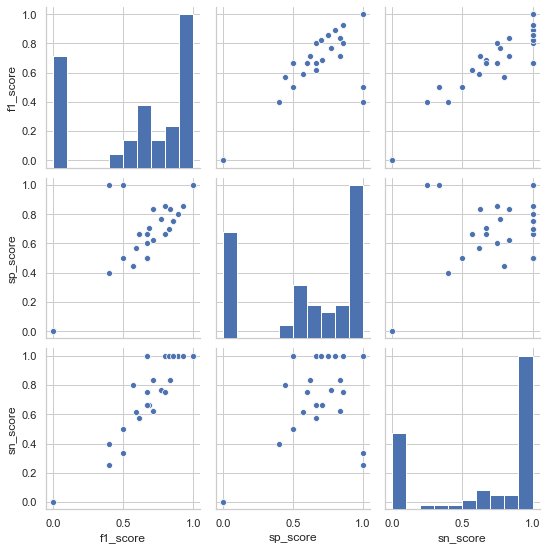

In [42]:
import seaborn as sns
sns.set(style='whitegrid')
sns.pairplot(Perf_CLS)

In [37]:
from sklearn.model_selection import cross_validate,LeaveOneOut
from sklearn.metrics import make_scorer,explained_variance_score,roc_auc_score,r2_score
from genra.rax.skl.reg import *


GC1 = GenRAPredValue(n_neighbors=8,algorithm='brute',metric='jaccard',n_jobs=2)

Loo = LeaveOneOut()
Loo.get_n_splits(X)
R = []
I = []
for trn_idx,tst_idx in Loo.split(X):
    X_trn,X_tst = X.iloc[trn_idx],X.iloc[tst_idx]
    Y_trn,Y_tst = Yf.iloc[trn_idx],Yf.iloc[tst_idx]
    Y_p = GC1.fit(X_trn,Y_trn).predict(X_tst)
    I.append(tst_idx[0])
    R.append(Y_p[0])

Perf1 = pd.DataFrame(dict(DTXSID=X.iloc[I].index,Y_true=Yb.iloc[I],Y_pred=R))\
          .reset_index(drop=True)\
          .merge(CLS1,on='DTXSID')

Perf1.loc[:,'Y_true']=Perf1.Y_true.astype(np.uint)
Grp = Perf1[['cluster','Y_true','Y_pred']].groupby('cluster')

def my_roc_score(Tr,Pr):
    if len(Tr.unique())==1:
        return None
    else:
        return roc_auc_score(Tr,Pr)
    
Perf_Val=pd.DataFrame(dict(auc_score=Grp.apply(lambda x: my_roc_score(x.Y_true,x.Y_pred)),
                           r2_score=Grp.apply(lambda x: r2_score(x.Y_true,x.Y_pred)),
                           expvr_score=Grp.apply(lambda x: explained_variance_score(x.Y_true,x.Y_pred))))
                                                                             
Perf_Val.sort_values('auc_score',ascending=False)

,auc_score,r2_score,expvr_score
cluster,,,
Cluster-88,1.000000,0.048752,0.290988
Cluster-10,0.875000,0.152522,0.175190
Cluster-6,0.785714,0.142524,0.153687
Cluster-59,0.714286,0.002582,0.024056
Cluster-35,0.566563,-0.086024,-0.083682
...,...,...,...
Cluster-87,NaN,NaN,1.000000
Cluster-89,NaN,NaN,1.000000
Cluster-96,NaN,0.000000,0.000000


In [39]:
del(P)

In [132]:
from sklearn.model_selection import cross_validate,LeaveOneOut
from sklearn.metrics import make_scorer,explained_variance_score,roc_auc_score,r2_score
from genra.rax.skl.reg import *
import pdb

def loocv_evaluate(Est,X_in,Y_in,**kwargs):
    Loo = LeaveOneOut()
    Loo.get_n_splits(X_in)
    R = []
    I = []
    for trn_idx,tst_idx in Loo.split(X_in):
        X_trn,X_tst = X_in.iloc[trn_idx],X_in.iloc[tst_idx]
        Y_trn,Y_tst = Y_in.iloc[trn_idx],Y_in.iloc[tst_idx]
        Y_p = Est.fit(X_trn,Y_trn).predict(X_tst)
        I.append(tst_idx[0])
        R.append(Y_p[0])

    Perf = pd.DataFrame(dict(DTXSID=X_in.iloc[I].index,
                             Y_true=Y_in.iloc[I],
                             Y_pred=R))\
              .reset_index(drop=True)
    Perf.loc[:,'Y_true']=Perf.Y_true.astype(np.uint)
    
    return Perf

def my_roc_score(Tr,Pr):
    if len(Tr.unique())==1:
        return None
    else:
        I1 = np.logical_and(pd.notnull(Pr),pd.notnull(Tr))
        return roc_auc_score(Tr[I1],Pr[I1])
    
def run_genra_val(X,Y,Cls=pd.DataFrame(),n=8,j=3):    
    GCi = GenRAPredValue(n_neighbors=n,algorithm='brute',
                         metric='jaccard',n_jobs=j)
    P  = loocv_evaluate(GCi,X,Y).dropna()
    if Cls.shape[0]>0:
        P   = P.merge(Cls,on='DTXSID')
        Grp = P[['cluster','Y_true','Y_pred']].groupby('cluster')
        Perf= pd.DataFrame(dict(auc_score=Grp.apply(lambda x: my_roc_score(x.Y_true,x.Y_pred)),
                                r2_score=Grp.apply(lambda x: r2_score(x.Y_true,x.Y_pred)),
                                expvr_score=Grp.apply(lambda x: explained_variance_score(x.Y_true,x.Y_pred))))
    else:
        Perf = pd.Series(dict(auc_score= my_roc_score(P.Y_true,P.Y_pred),
                                r2_score = r2_score(P.Y_true,P.Y_pred),
                                expvr_score=explained_variance_score(P.Y_true,P.Y_pred)))    
    return Perf

def run_genra_cls(X,Y,Cls=pd.DataFrame(),n=8,j=3):    
    GCi = GenRAPredClass(n_neighbors=n,algorithm='brute',
                         metric='jaccard',n_jobs=j)
    P  = loocv_evaluate(GCi,X,Y).dropna()
    if Cls.shape[0]>0:
        P   = P.merge(Cls,on='DTXSID')
        Grp = P[['cluster','Y_true','Y_pred']].groupby('cluster')
        Perf= pd.DataFrame(dict(f1_score=Grp.apply(lambda x: f1_score(x.Y_true,x.Y_pred)),
                               sp_score=Grp.apply(lambda x: precision_score(x.Y_true,x.Y_pred)),
                               sn_score=Grp.apply(lambda x: recall_score(x.Y_true,x.Y_pred))))
    else:
        Perf = pd.Series(dict(f1_score= f1_score(P.Y_true,P.Y_pred),
                              sp_score = precision_score(P.Y_true,P.Y_pred),
                              sn_score=recall_score(P.Y_true,P.Y_pred)))    
    return Perf

<font size = "3">Chemical descriptor performance Liver Endpoints</font>

In [46]:
PERF_chm=[]
Chm  = list(CHM11.keys())

for Effect in TOX1.filter(regex = '_liver$'):
    #print(Effect)
    Yf = TOX1[Effect].dropna()
    Yf[Yf>0]=1
    Yb = Yf.copy()
    Yb = Yb.astype(np.int)
    
    for C in Chm:
        INT = CHM11[C].index.intersection(Yb.index)
        if len(INT)>0:
            X= CHM11[C].loc[INT].dropna()
            Yb= Yb.loc[X.index]
            Yf= Yf.loc[X.index]
        if X.shape[0]>20:
            print(Effect,C,X.shape)
            P1 = run_genra_cls(X,Yb).to_dict()
            P2 = run_genra_val(X,Yf).to_dict()
            P1.update(P2)
            P1.update(dict(tox=Effect,dt='chm',dn=C))
            PERF_chm.append(P1)

    X = CHM1.loc[INT]
    Yb= Yb.loc[X.index]
    Yf= Yf.loc[X.index]
    if X.shape[0]>20:
        print(C,X.shape)
        P1 = run_genra_cls(X,Yb).to_dict()
        P2 = run_genra_val(X,Yf).to_dict()
        P1.update(P2)
        P1.update(dict(tox=Effect,dt='chm',dn='all'))
        PERF_chm.append(P1)
        break

chr_liver mrgn (364, 2048)
chr_liver toxp (364, 729)
chr_liver tptr (364, 2048)
tptr (364, 4825)


In [47]:
PERF_chm=pd.DataFrame(PERF_chm).sort_values('auc_score',ascending=False)

In [48]:
PERF_chm

,f1_score,sp_score,sn_score,auc_score,r2_score,expvr_score,tox,dt,dn
3,0.718816,0.717300,0.720339,0.677271,0.038399,0.038468,chr_liver,chm,all
0,0.738144,0.718876,0.758475,0.652642,0.002710,0.003289,chr_liver,chm,mrgn
1,0.722581,0.733624,0.711864,0.636024,0.007438,0.007577,chr_liver,chm,toxp
2,0.696721,0.674603,0.720339,0.617982,-0.031148,-0.030888,chr_liver,chm,tptr


In [49]:
PERF_chm.to_csv(TOP + '/tables/globall_perf_all_liver_chm.csv')

<font size = "3">Biological descriptor performance Liver Endpoints</font>

In [50]:
PERF_bio=[]
Bio  = list(BIO11.keys())

for Effect in TOX1.filter(regex = '_liver$'):
    #print(Effect)
    Yf = TOX1[Effect].dropna()
    Yf[Yf>0]=1
    Yb = Yf.copy()
    Yb = Yb.astype(np.int)
    
    for B in Bio:
        INT = BIO11[B].index.intersection(Yb.index)
        if len(INT)>0:
            X= BIO11[B].loc[INT].dropna()
            Yb= Yb.loc[X.index]
            Yf= Yf.loc[X.index]
        if X.shape[0]>20:
            print(Effect,B,X.shape)
            P1 = run_genra_cls(X,Yb).to_dict()
            P2 = run_genra_val(X,Yf).to_dict()
            P1.update(P2)
            P1.update(dict(tox=Effect,dt='bio',dn=B))
            PERF_bio.append(P1)

    X = BIO1.loc[INT]
    Yb= Yb.loc[X.index]
    Yf= Yf.loc[X.index]
    if X.shape[0]>20:
        print(B,X.shape)
        P1 = run_genra_cls(X,Yb).to_dict()
        P2 = run_genra_val(X,Yf).to_dict()
        P1.update(P2)
        P1.update(dict(tox=Effect,dt='bio',dn='all'))
        PERF_bio.append(P1)
        break

chr_liver assay (379, 189)
chr_liver gene (379, 95)
gene (379, 284)


In [51]:
PERF_bio=pd.DataFrame(PERF_bio).sort_values('auc_score',ascending=False)

In [52]:
PERF_bio

,f1_score,sp_score,sn_score,auc_score,r2_score,expvr_score,tox,dt,dn
2,0.719682,0.701550,0.738776,0.634800,-0.019644,-0.019608,chr_liver,bio,all
1,0.720472,0.695817,0.746939,0.627368,-0.028030,-0.027315,chr_liver,bio,gene
0,0.718563,0.703125,0.734694,0.623987,-0.039774,-0.039768,chr_liver,bio,assay


In [53]:
PERF_bio.to_csv(TOP + '/tables/globall_perf_all_liver_bio.csv')

<font size = "3">Combination of Chemical and Biological Descriptors _Global Analysis for Liver Endpoints</font>

In [54]:
cb = pd.concat((BIO1, CHM1), axis = 1, join = 'inner')

In [55]:
cb11 = Box()
for i in set([i[0] for i in cb.columns.str.split('_')]):
    cb11[i]=cb[cb.columns[cb.columns.str.match(i)]]
    
list(cb11.keys())

['tptr', 'assay', 'mrgn', 'toxp', 'gene']

In [56]:
PERF_cb=[]
CB  = list(cb11.keys())

for Effect in TOX1.filter(regex = '_liver$'):
    #print(Effect)
    Yf = TOX1[Effect].dropna()
    Yf[Yf>0]=1
    Yb = Yf.copy()
    Yb = Yb.astype(np.int)
    
    for D in CB:
        INT = cb11[D].index.intersection(Yb.index)
        if len(INT)>0:
            X= cb11[D].loc[INT].dropna()
            Yb= Yb.loc[X.index]
            Yf= Yf.loc[X.index]
        if X.shape[0]>20:
            print(Effect,D,X.shape)
            P1 = run_genra_cls(X,Yb).to_dict()
            P2 = run_genra_val(X,Yf).to_dict()
            P1.update(P2)
            P1.update(dict(tox=Effect,dt='descriptor',dn=D))
            PERF_cb.append(P1)

    X = cb.loc[INT]
    Yb= Yb.loc[X.index]
    Yf= Yf.loc[X.index]
    if X.shape[0]>20:
        print(C,X.shape)
        P1 = run_genra_cls(X,Yb).to_dict()
        P2 = run_genra_val(X,Yf).to_dict()
        P1.update(P2)
        P1.update(dict(tox=Effect,dt='descriptor',dn='all'))
        PERF_cb.append(P1)
        break

chr_liver tptr (364, 2048)
chr_liver assay (364, 189)
chr_liver mrgn (364, 2048)
chr_liver toxp (364, 729)
chr_liver gene (364, 95)
tptr (364, 5109)


In [57]:
PERF_cb=pd.DataFrame(PERF_cb).sort_values('auc_score',ascending=False)

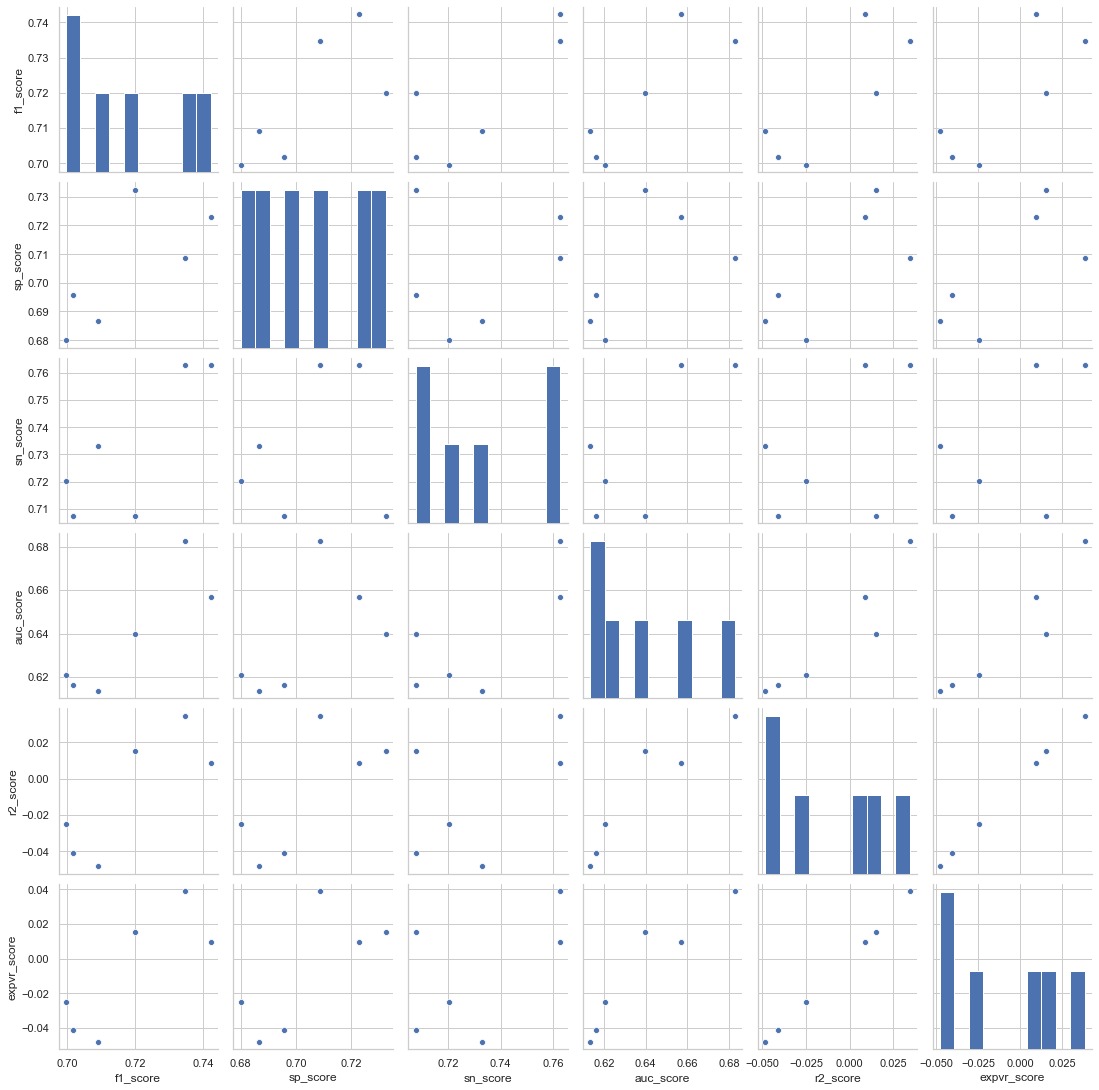

In [58]:
import seaborn as sns
sns.set(style='whitegrid')
PERF_cb_fig = sns.pairplot(PERF_cb)

In [59]:
PERF_cb_fig.savefig(TOP +'/figs/global_performance_chr_liver_all.png')

<font size = "3">Combination Morgan/Gene Descriptor Performance Analysis Liver Endpoints</font>

In [44]:
gene = BIO1.filter(regex='^gene', axis=1)

In [121]:
gene.head()

,gene_ ABCB1,gene_ ABCB11,gene_ ABCC2,gene_ ABCC3,gene_ ABCG2,gene_ ACLY,gene_ ACOX1,gene_ ADK,gene_ AFP,gene_ ALPP,...,gene_ SULT2A1,gene_ TGFA,gene_ TGFB1,gene_ THRSP,gene_ TIMP1,gene_ TNFRSF1A,gene_ TP53,gene_ UGT1A1,gene_ UGT1A6,gene_ XBP1
DTXSID,,,,,,,,,,,,,,,,,,,,,
DTXSID5020281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID8020961,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0021834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID5021837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID5020152,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
gen11= Box()
for i in set([i[0] for i in gene.columns.str.split('_')]):
    gen11[i]=gene[gene.columns[gene.columns.str.match(i)]]
list(gen11.keys())

['gene']

In [45]:
assay = BIO1.filter(regex='^assay', axis=1)
assay.head()

,assay_ABCB1_dn,assay_ABCB1_up,assay_ABCB11_dn,assay_ABCB11_up,assay_ABCC2_dn,assay_ABCC2_up,assay_ABCC3_dn,assay_ABCC3_up,assay_ABCG2_dn,assay_ABCG2_up,...,assay_TNFRSF1A_dn,assay_TNFRSF1A_up,assay_TP53_dn,assay_TP53_up,assay_UGT1A1_dn,assay_UGT1A1_up,assay_UGT1A6_dn,assay_UGT1A6_up,assay_XBP1_dn,assay_XBP1_up
DTXSID,,,,,,,,,,,,,,,,,,,,,
DTXSID5020281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID8020961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0021834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID5021837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID5020152,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
mrgn = CHM1.filter(regex='^mrgn', axis = 1)
mrgn.head()

,mrgn_0,mrgn_1,mrgn_2,mrgn_3,mrgn_4,mrgn_5,mrgn_6,mrgn_7,mrgn_8,mrgn_9,...,mrgn_2038,mrgn_2039,mrgn_2040,mrgn_2041,mrgn_2042,mrgn_2043,mrgn_2044,mrgn_2045,mrgn_2046,mrgn_2047
DTXSID,,,,,,,,,,,,,,,,,,,,,
DTXSID9020035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID2020260,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID2021735,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID8041030,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
DTXSID6021080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
mrg11 = Box()
for i in set([i[0] for i in mrgn.columns.str.split('_')]):
    mrg11[i]=mrgn[mrgn.columns[mrgn.columns.str.match(i)]]
list(mrg11.keys())

['mrgn']

In [47]:
tptr = CHM1.filter(regex='^tptr', axis = 1)
tptr.head()

,tptr_0,tptr_1,tptr_2,tptr_3,tptr_4,tptr_5,tptr_6,tptr_7,tptr_8,tptr_9,...,tptr_2038,tptr_2039,tptr_2040,tptr_2041,tptr_2042,tptr_2043,tptr_2044,tptr_2045,tptr_2046,tptr_2047
DTXSID,,,,,,,,,,,,,,,,,,,,,
DTXSID9020035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID2020260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID2021735,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID8041030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID6021080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
toxp = CHM1.filter(regex='^toxp', axis = 1)
toxp.head()

,toxp_atom:element_main_group,toxp_atom:element_metal_group_I_II,toxp_atom:element_metal_group_III,toxp_atom:element_metal_metalloid,toxp_atom:element_metal_poor_metal,toxp_atom:element_metal_transistion_metal,toxp_atom:element_noble_gas,toxp_bond:C#N_cyano_acylcyanide,toxp_bond:C#N_cyano_cyanamide,toxp_bond:C#N_cyano_cyanohydrin,...,toxp_ring:polycycle_bicyclo_propene,toxp_ring:polycycle_spiro_[2.2]pentane,toxp_ring:polycycle_spiro_[2.5]octane,toxp_ring:polycycle_spiro_[4.5]decane,toxp_ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane,toxp_ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene,toxp_ring:polycycle_tricyclo_[3.7.7]bullvalene,toxp_ring:polycycle_tricyclo_[3.7.7]semibullvalene,toxp_ring:polycycle_tricyclo_adamantane,toxp_ring:polycycle_tricyclo_benzvalene
DTXSID,,,,,,,,,,,,,,,,,,,,,
DTXSID9020035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID2020260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID2021735,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID8041030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID6021080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
#mrgn(CHM) and gene(BIO)
mg = pd.concat((gene, mrgn), axis =1 , join = 'inner')
mg.head()

,gene_ ABCB1,gene_ ABCB11,gene_ ABCC2,gene_ ABCC3,gene_ ABCG2,gene_ ACLY,gene_ ACOX1,gene_ ADK,gene_ AFP,gene_ ALPP,...,mrgn_2038,mrgn_2039,mrgn_2040,mrgn_2041,mrgn_2042,mrgn_2043,mrgn_2044,mrgn_2045,mrgn_2046,mrgn_2047
DTXSID,,,,,,,,,,,,,,,,,,,,,
DTXSID5020281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID8020961,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0021834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID5021837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID5020152,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [124]:
mg.shape

(1016, 2143)

In [125]:
mg11 = Box()
for i in set([i[0] for i in mg.columns.str.split('_')]):
    mg11[i]=mg[mg.columns[mg.columns.str.match(i)]]
list(mg11.keys())

['mrgn', 'gene']

In [141]:
PERF_mg=[]
MG  = list(mg11.keys())

for Effect in TOX1.filter(regex = '_liver$'):
    #print(Effect)
    Yf = TOX1[Effect].dropna()
    Yf[Yf>0]=1
    Yb = Yf.copy()
    Yb = Yb.astype(np.int)
    
    for D in MG:
        INT = mg11[D].index.intersection(Yb.index)
        if len(INT)>0:
            X= mg11[D].loc[INT].dropna()
            Yb= Yb.loc[X.index]
            Yf= Yf.loc[X.index]
        if X.shape[0]>20:
            print(Effect,D,X.shape)
            P1 = run_genra_cls(X,Yb).to_dict()
            P2 = run_genra_val(X,Yf).to_dict()
            P1.update(P2)
            P1.update(dict(tox=Effect,dt=D ,dn=D))
            PERF_mg.append(P1)

    X = mg.loc[INT]
    Yb= Yb.loc[X.index]
    Yf= Yf.loc[X.index]
    if X.shape[0]>20:
        print(D,X.shape)
        P1 = run_genra_cls(X,Yb).to_dict()
        P2 = run_genra_val(X,Yf).to_dict()
        P1.update(P2)
        P1.update(dict(tox=Effect,dt='gene/mrgn',dn='gene/mrgn'))
        PERF_mg.append(P1)
        break

chr_liver mrgn (364, 2048)
chr_liver gene (364, 95)
gene (364, 2143)


In [142]:
PERF_mg=pd.DataFrame(PERF_mg).sort_values('f1_score',ascending=False)

In [143]:
PERF_mg

,f1_score,sp_score,sn_score,auc_score,r2_score,expvr_score,tox,dt,dn
2,0.765625,0.710145,0.830508,0.693872,0.055384,0.065762,chr_liver,gene/mrgn,gene/mrgn
0,0.742268,0.722892,0.762712,0.656945,0.008783,0.009392,chr_liver,mrgn,mrgn
1,0.709016,0.686508,0.733051,0.613563,-0.048386,-0.047930,chr_liver,gene,gene


In [72]:
PERF_mg.to_csv(TOP + '/tables/global_perf_liver_mg.csv')

<font size = "3" >Automated Performance Tuning on data sets:</font>

    cb=chm/bio(all)
    ca=chm(all)
    mg=mrgn/gene
    ma=mrgn/assay
    txg=toxp/gene
    txa=toxp/assay
    ttg=tptr/gene
    tta=tptr/assay

combs = all data combination (all above)

<font size = "2" >Generate Gombinations and Box file</font>

In [50]:
cb = pd.concat((BIO1, CHM1), axis =1 , join = 'inner')
cb = cb.add_prefix('cb_')
mg = pd.concat((gene, mrgn), axis =1 , join = 'inner')
mg = mg.add_prefix('mg_')
ma = pd.concat((assay, mrgn), axis =1 , join = 'inner')
ma = ma.add_prefix('ma_')
txg = pd.concat((gene, toxp), axis =1 , join = 'inner')
txg = txg.add_prefix('txg_')
txa = pd.concat((assay, toxp), axis =1 , join = 'inner')
txa = txa.add_prefix('txa_')
ttg = pd.concat((gene, tptr), axis =1 , join = 'inner')
ttg = ttg.add_prefix('ttg_')
tta = pd.concat((assay, tptr), axis =1 , join = 'inner')
tta = tta.add_prefix('tta_')
ca = CHM1
ca = ca.add_prefix('ca_')

In [51]:
combs= pd.concat((cb,mg,ma,txg,txa,ttg,tta,ca), axis= 1, join = 'inner')

In [52]:
COMBS11 = Box()
for i in set([i[0] for i in combs.columns.str.split('_') ]):
    COMBS11[i] =  combs[combs.columns[combs.columns.str.match(i)]]
    
list(COMBS11.keys())

['tta', 'cb', 'txa', 'ttg', 'mg', 'txg', 'ma', 'ca']

In [67]:
MG11 = Box()
for i in set([i[0] for i in mg.columns.str.split('_') ]):
    MG11[i] =  mg[mg.columns[mg.columns.str.match(i)]]
    
list(MG11.keys())

['mg']

In [383]:
GC1 = GenRAPredValue(algorithm='brute')

params={'n_neighbors': range(1,15),
        'metric':['euclidean','jaccard','manhattan']
       }


Grid3= GridSearchCV(estimator=GC1,param_grid=params,
                    n_jobs=-1,cv=5,#LeaveOneOut(),
                    verbose=1,
                    scoring=make_scorer(roc_auc_score))


Comb = list(COMBS11.keys())

for Effect in TOX1.filter(regex = '^chr_'):#TOX1.columns:
    #print(Effect)
    Yf = TOX1[Effect].dropna()
    Yf[Yf>0]=1
    Yb = Yf.copy()
    Yb = Yb.astype(np.int)
   
    
    for C in Comb:
        INT=COMBS11[C].index.intersection(Yb.index)
        if len(INT)>0:
            X =COMBS11[C].loc[INT].dropna()
            Yb=Yb.loc[X.index]
            Yf=Yf.loc[X.index]
        if X.shape[0]>20:
            try:
            #print(Effect,C,X.shape, file = open('combs_perf.csv', 'a') )
                Best3 = Grid3.fit(X,Yb)
                print(Effect,C,X.shape)#, file = open('combs_perf.csv', 'a') )
                print(Best3.best_score_,Best3.best_params_)#, file = open('combs_perf.csv', 'a'))
            except ValueError:
                pass

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_.other. tta (364, 2237)
0.6435580147551978 {'metric': 'jaccard', 'n_neighbors': 13}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   25.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_.other. cb (364, 5109)
0.6012348001049777 {'metric': 'jaccard', 'n_neighbors': 8}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_.other. txa (364, 918)
0.6257201178082991 {'metric': 'jaccard', 'n_neighbors': 10}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_.other. ttg (364, 2143)
0.6122686845711953 {'metric': 'jaccard', 'n_neighbors': 2}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_.other. mg (364, 2143)
0.6045010643571574 {'metric': 'jaccard', 'n_neighbors': 8}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_.other. txg (364, 824)
0.6456443005861254 {'metric': 'jaccard', 'n_neighbors': 11}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_.other. ma (364, 2237)
0.5772109468404631 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   27.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_.other. ca (364, 4825)
0.4856297203510921 {'metric': 'jaccard', 'n_neighbors': 1}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_adrenal_gland tta (364, 2237)
0.6475673300786731 {'metric': 'euclidean', 'n_neighbors': 9}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   30.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_adrenal_gland cb (364, 5109)
0.6024702684389617 {'metric': 'manhattan', 'n_neighbors': 9}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_adrenal_gland txa (364, 918)
0.5679419632595677 {'metric': 'jaccard', 'n_neighbors': 2}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_adrenal_gland ttg (364, 2143)
0.6189606380713459 {'metric': 'jaccard', 'n_neighbors': 3}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_adrenal_gland mg (364, 2143)
0.5823712343313069 {'metric': 'euclidean', 'n_neighbors': 7}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_adrenal_gland txg (364, 824)
0.5486176366484896 {'metric': 'jaccard', 'n_neighbors': 6}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_adrenal_gland ma (364, 2237)
0.5966792858784692 {'metric': 'manhattan', 'n_neighbors': 7}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   28.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_adrenal_gland ca (364, 4825)
0.6021715708671244 {'metric': 'jaccard', 'n_neighbors': 5}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_alanine_aminotransferase_.alt.sgpt. tta (364, 2237)
0.7200587391265358 {'metric': 'euclidean', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   25.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_alanine_aminotransferase_.alt.sgpt. cb (364, 5109)
0.6753059443069966 {'metric': 'jaccard', 'n_neighbors': 12}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_alanine_aminotransferase_.alt.sgpt. txa (364, 918)
0.6762947313263034 {'metric': 'jaccard', 'n_neighbors': 12}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_alanine_aminotransferase_.alt.sgpt. ttg (364, 2143)
0.6800798574294753 {'metric': 'jaccard', 'n_neighbors': 12}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_alanine_aminotransferase_.alt.sgpt. mg (364, 2143)
0.6837453292679282 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_alanine_aminotransferase_.alt.sgpt. txg (364, 824)
0.6818251491850141 {'metric': 'euclidean', 'n_neighbors': 13}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_alanine_aminotransferase_.alt.sgpt. ma (364, 2237)
0.6532703520830806 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   23.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_alanine_aminotransferase_.alt.sgpt. ca (364, 4825)
0.6314857030906106 {'metric': 'euclidean', 'n_neighbors': 4}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_albumin tta (364, 2237)
0.6355218645251378 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   25.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_albumin cb (364, 5109)
0.7080281400280828 {'metric': 'jaccard', 'n_neighbors': 10}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_albumin txa (364, 918)
0.649962769286547 {'metric': 'jaccard', 'n_neighbors': 13}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_albumin ttg (364, 2143)
0.6168395944438049 {'metric': 'jaccard', 'n_neighbors': 13}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_albumin mg (364, 2143)
0.6452805103880609 {'metric': 'jaccard', 'n_neighbors': 13}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_albumin txg (364, 824)
0.6650153144942624 {'metric': 'jaccard', 'n_neighbors': 12}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_albumin ma (364, 2237)
0.6373580276558194 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   23.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_albumin ca (364, 4825)
0.730984452620327 {'metric': 'jaccard', 'n_neighbors': 7}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_albumin.globulin_ratio tta (364, 2237)
0.5930669633200457 {'metric': 'jaccard', 'n_neighbors': 5}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   25.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_albumin.globulin_ratio cb (364, 5109)
0.6194021352863015 {'metric': 'jaccard', 'n_neighbors': 8}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_albumin.globulin_ratio txa (364, 918)
0.5069520410370507 {'metric': 'euclidean', 'n_neighbors': 6}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_albumin.globulin_ratio ttg (364, 2143)
0.6160107845863848 {'metric': 'jaccard', 'n_neighbors': 7}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_albumin.globulin_ratio mg (364, 2143)
0.6392026667902722 {'metric': 'jaccard', 'n_neighbors': 4}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_albumin.globulin_ratio txg (364, 824)
0.5353624475963865 {'metric': 'manhattan', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_albumin.globulin_ratio ma (364, 2237)
0.5691156021136553 {'metric': 'jaccard', 'n_neighbors': 3}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   23.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_albumin.globulin_ratio ca (364, 4825)
0.7265696877929194 {'metric': 'jaccard', 'n_neighbors': 11}
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_alkaline_phosphatase_.alp.alk. tta (364, 2237)
0.6065001588961966 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   25.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_alkaline_phosphatase_.alp.alk. cb (364, 5109)
0.6278734904017926 {'metric': 'jaccard', 'n_neighbors': 11}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_alkaline_phosphatase_.alp.alk. txa (364, 918)
0.5931259509313251 {'metric': 'jaccard', 'n_neighbors': 13}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_alkaline_phosphatase_.alp.alk. ttg (364, 2143)
0.6046732762086701 {'metric': 'manhattan', 'n_neighbors': 6}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_alkaline_phosphatase_.alp.alk. mg (364, 2143)
0.6423940236587778 {'metric': 'jaccard', 'n_neighbors': 10}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_alkaline_phosphatase_.alp.alk. txg (364, 824)
0.5949636101845603 {'metric': 'jaccard', 'n_neighbors': 8}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_alkaline_phosphatase_.alp.alk. ma (364, 2237)
0.6210992050167267 {'metric': 'jaccard', 'n_neighbors': 13}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   24.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_alkaline_phosphatase_.alp.alk. ca (364, 4825)
0.6152966585243143 {'metric': 'jaccard', 'n_neighbors': 5}
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_anemia tta (364, 2237)
0.5364018188734396 {'metric': 'euclidean', 'n_neighbors': 5}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   32.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_anemia cb (364, 5109)
0.6515212752468376 {'metric': 'euclidean', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_anemia txa (364, 918)
0.522362700247922 {'metric': 'jaccard', 'n_neighbors': 11}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   11.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_anemia ttg (364, 2143)
0.5363235215605406 {'metric': 'euclidean', 'n_neighbors': 12}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_anemia mg (364, 2143)
0.5385959037808943 {'metric': 'jaccard', 'n_neighbors': 12}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_anemia txg (364, 824)
0.6011313819901165 {'metric': 'jaccard', 'n_neighbors': 10}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_anemia ma (364, 2237)
0.5962489280625711 {'metric': 'euclidean', 'n_neighbors': 13}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   26.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_anemia ca (364, 4825)
0.5470569102842595 {'metric': 'euclidean', 'n_neighbors': 5}
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_aspartate_aminotransferase_.ast.sgot. tta (364, 2237)
0.6109717879482307 {'metric': 'jaccard', 'n_neighbors': 6}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   25.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_aspartate_aminotransferase_.ast.sgot. cb (364, 5109)
0.6189690441280721 {'metric': 'jaccard', 'n_neighbors': 12}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_aspartate_aminotransferase_.ast.sgot. txa (364, 918)
0.594756322481337 {'metric': 'manhattan', 'n_neighbors': 13}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_aspartate_aminotransferase_.ast.sgot. ttg (364, 2143)
0.5995027395196132 {'metric': 'jaccard', 'n_neighbors': 12}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_aspartate_aminotransferase_.ast.sgot. mg (364, 2143)
0.6473447674193796 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_aspartate_aminotransferase_.ast.sgot. txg (364, 824)
0.6355164444286068 {'metric': 'euclidean', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_aspartate_aminotransferase_.ast.sgot. ma (364, 2237)
0.6120038876082786 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   24.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_aspartate_aminotransferase_.ast.sgot. ca (364, 4825)
0.6235366089545404 {'metric': 'jaccard', 'n_neighbors': 10}
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bilirubin tta (364, 2237)
0.6679077343056482 {'metric': 'jaccard', 'n_neighbors': 11}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   26.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bilirubin cb (364, 5109)
0.6556916586133053 {'metric': 'jaccard', 'n_neighbors': 8}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bilirubin txa (364, 918)
0.5129158449798081 {'metric': 'jaccard', 'n_neighbors': 1}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bilirubin ttg (364, 2143)
0.7175277178153495 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bilirubin mg (364, 2143)
0.6503744432494294 {'metric': 'jaccard', 'n_neighbors': 5}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bilirubin txg (364, 824)
0.5127815297936968 {'metric': 'jaccard', 'n_neighbors': 13}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bilirubin ma (364, 2237)
0.515143555124155 {'metric': 'euclidean', 'n_neighbors': 1}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   25.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bilirubin ca (364, 4825)
0.6660744767990796 {'metric': 'euclidean', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_blood tta (364, 2237)
0.5405196269036903 {'metric': 'euclidean', 'n_neighbors': 13}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   26.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_blood cb (364, 5109)
0.6633136807382193 {'metric': 'manhattan', 'n_neighbors': 11}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_blood txa (364, 918)
0.802483435048074 {'metric': 'euclidean', 'n_neighbors': 12}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_blood ttg (364, 2143)
0.513154642888313 {'metric': 'jaccard', 'n_neighbors': 2}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_blood mg (364, 2143)
0.6704015561859917 {'metric': 'jaccard', 'n_neighbors': 10}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_blood txg (364, 824)
0.7849853163336242 {'metric': 'euclidean', 'n_neighbors': 11}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_blood ma (364, 2237)
0.6806487345648883 {'metric': 'jaccard', 'n_neighbors': 12}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   25.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_blood ca (364, 4825)
0.6067822566962642 {'metric': 'manhattan', 'n_neighbors': 10}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_blood_clotting tta (364, 2237)
0.5688689018166972 {'metric': 'jaccard', 'n_neighbors': 6}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   26.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_blood_clotting cb (364, 5109)
0.6388029412622366 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 203 out of 210 | elapsed:    5.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_blood_clotting txa (364, 918)
0.6163954657184367 {'metric': 'jaccard', 'n_neighbors': 10}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_blood_clotting ttg (364, 2143)
0.5640788121739816 {'metric': 'euclidean', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_blood_clotting mg (364, 2143)
0.6562515587986573 {'metric': 'jaccard', 'n_neighbors': 13}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_blood_clotting txg (364, 824)
0.6390166617779995 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_blood_clotting ma (364, 2237)
0.6058549785499012 {'metric': 'jaccard', 'n_neighbors': 4}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   26.7s finished


chr_blood_clotting ca (364, 4825)
0.6144310020395176 {'metric': 'jaccard', 'n_neighbors': 7}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_body_weight tta (364, 2237)
0.5438114316239316 {'metric': 'jaccard', 'n_neighbors': 3}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   29.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_body_weight cb (364, 5109)
0.5838167735042734 {'metric': 'manhattan', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_body_weight txa (364, 918)
0.5587686965811965 {'metric': 'euclidean', 'n_neighbors': 11}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_body_weight ttg (364, 2143)
0.5640598290598291 {'metric': 'jaccard', 'n_neighbors': 8}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_body_weight mg (364, 2143)
0.5727270299145297 {'metric': 'jaccard', 'n_neighbors': 5}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_body_weight txg (364, 824)
0.558127670940171 {'metric': 'euclidean', 'n_neighbors': 2}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_body_weight ma (364, 2237)
0.5579059829059829 {'metric': 'euclidean', 'n_neighbors': 2}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   25.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_body_weight ca (364, 4825)
0.5459748931623932 {'metric': 'euclidean', 'n_neighbors': 1}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bone tta (364, 2237)
0.6949345090148735 {'metric': 'jaccard', 'n_neighbors': 11}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   35.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bone cb (364, 5109)
0.7137446246104074 {'metric': 'jaccard', 'n_neighbors': 10}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bone txa (364, 918)
0.6830770242369247 {'metric': 'euclidean', 'n_neighbors': 8}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bone ttg (364, 2143)
0.6424223116476637 {'metric': 'euclidean', 'n_neighbors': 5}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bone mg (364, 2143)
0.6902442103602004 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bone txg (364, 824)
0.5930206730579556 {'metric': 'euclidean', 'n_neighbors': 8}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bone ma (364, 2237)
0.6787324601201983 {'metric': 'jaccard', 'n_neighbors': 13}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   27.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bone ca (364, 4825)
0.49857142857142855 {'metric': 'euclidean', 'n_neighbors': 1}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bone_marrow tta (364, 2237)
0.5851753535238285 {'metric': 'jaccard', 'n_neighbors': 6}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   28.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bone_marrow cb (364, 5109)
0.6003384712842857 {'metric': 'jaccard', 'n_neighbors': 4}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bone_marrow txa (364, 918)
0.5716513110510515 {'metric': 'euclidean', 'n_neighbors': 1}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bone_marrow ttg (364, 2143)
0.570668842837889 {'metric': 'jaccard', 'n_neighbors': 10}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bone_marrow mg (364, 2143)
0.5818954796015147 {'metric': 'jaccard', 'n_neighbors': 4}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bone_marrow txg (364, 824)
0.5224680467704478 {'metric': 'euclidean', 'n_neighbors': 1}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bone_marrow ma (364, 2237)
0.6149330628272873 {'metric': 'jaccard', 'n_neighbors': 3}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   26.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_bone_marrow ca (364, 4825)
0.6631519956357724 {'metric': 'jaccard', 'n_neighbors': 7}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_brain tta (364, 2237)
0.626333653735706 {'metric': 'jaccard', 'n_neighbors': 6}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   36.3s finished


chr_brain cb (364, 5109)
0.567991975202796 {'metric': 'euclidean', 'n_neighbors': 4}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_brain txa (364, 918)
0.5818337508838131 {'metric': 'jaccard', 'n_neighbors': 6}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_brain ttg (364, 2143)
0.5711219656633213 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_brain mg (364, 2143)
0.551849740169081 {'metric': 'euclidean', 'n_neighbors': 11}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_brain txg (364, 824)
0.5698078639620928 {'metric': 'euclidean', 'n_neighbors': 13}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_brain ma (364, 2237)
0.5710909211251252 {'metric': 'euclidean', 'n_neighbors': 4}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   34.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_brain ca (364, 4825)
0.5420309391640237 {'metric': 'euclidean', 'n_neighbors': 7}
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_calcium tta (364, 2237)
0.5317243707507026 {'metric': 'jaccard', 'n_neighbors': 3}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   26.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_calcium cb (364, 5109)
0.5888482735880164 {'metric': 'jaccard', 'n_neighbors': 3}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_calcium txa (364, 918)
0.5462538665661753 {'metric': 'euclidean', 'n_neighbors': 2}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_calcium ttg (364, 2143)
0.5652656219741339 {'metric': 'jaccard', 'n_neighbors': 11}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_calcium mg (364, 2143)
0.5850492774558911 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_calcium txg (364, 824)
0.5480254604550379 {'metric': 'jaccard', 'n_neighbors': 1}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_calcium ma (364, 2237)
0.5804467421399448 {'metric': 'euclidean', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   25.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_calcium ca (364, 4825)
0.6237449950539357 {'metric': 'jaccard', 'n_neighbors': 6}
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_cholesterol tta (364, 2237)
0.6099421068308122 {'metric': 'jaccard', 'n_neighbors': 5}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   26.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_cholesterol cb (364, 5109)
0.6475824051146054 {'metric': 'jaccard', 'n_neighbors': 9}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_cholesterol txa (364, 918)
0.6146600801555819 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_cholesterol ttg (364, 2143)
0.65152245444231 {'metric': 'jaccard', 'n_neighbors': 11}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_cholesterol mg (364, 2143)
0.6241399565195597 {'metric': 'manhattan', 'n_neighbors': 9}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_cholesterol txg (364, 824)
0.6464860858197664 {'metric': 'jaccard', 'n_neighbors': 12}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_cholesterol ma (364, 2237)
0.6126783576391878 {'metric': 'euclidean', 'n_neighbors': 12}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   25.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_cholesterol ca (364, 4825)
0.650035109357987 {'metric': 'jaccard', 'n_neighbors': 13}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_cholinesterase tta (364, 2237)
0.910091649554511 {'metric': 'jaccard', 'n_neighbors': 4}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   26.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_cholinesterase cb (364, 5109)
0.9205111827089473 {'metric': 'jaccard', 'n_neighbors': 3}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_cholinesterase txa (364, 918)
0.8948669952713363 {'metric': 'jaccard', 'n_neighbors': 6}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_cholinesterase ttg (364, 2143)
0.8700185804177343 {'metric': 'jaccard', 'n_neighbors': 5}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_cholinesterase mg (364, 2143)
0.9261818669151534 {'metric': 'jaccard', 'n_neighbors': 4}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_cholinesterase txg (364, 824)
0.9077835320685927 {'metric': 'jaccard', 'n_neighbors': 8}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_cholinesterase ma (364, 2237)
0.9313234285275229 {'metric': 'jaccard', 'n_neighbors': 6}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   25.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_cholinesterase ca (364, 4825)
0.9543872342806287 {'metric': 'jaccard', 'n_neighbors': 4}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_clinical_signs tta (364, 2237)
0.5676764783078954 {'metric': 'jaccard', 'n_neighbors': 12}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   26.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_clinical_signs cb (364, 5109)
0.5811426582052974 {'metric': 'jaccard', 'n_neighbors': 9}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_clinical_signs txa (364, 918)
0.5396373494969489 {'metric': 'jaccard', 'n_neighbors': 13}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 203 out of 210 | elapsed:    6.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_clinical_signs ttg (364, 2143)
0.5797675006713694 {'metric': 'jaccard', 'n_neighbors': 5}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_clinical_signs mg (364, 2143)
0.5626424955171554 {'metric': 'jaccard', 'n_neighbors': 12}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_clinical_signs txg (364, 824)
0.5585829776925615 {'metric': 'jaccard', 'n_neighbors': 6}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_clinical_signs ma (364, 2237)
0.5758664802162762 {'metric': 'jaccard', 'n_neighbors': 7}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   25.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_clinical_signs ca (364, 4825)
0.620579696440579 {'metric': 'jaccard', 'n_neighbors': 12}
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_creatine_phosphokinase tta (364, 2237)
0.6223200312989046 {'metric': 'jaccard', 'n_neighbors': 11}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   26.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_creatine_phosphokinase cb (364, 5109)
0.5947965571205007 {'metric': 'jaccard', 'n_neighbors': 4}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_creatine_phosphokinase txa (364, 918)
0.616431924882629 {'metric': 'euclidean', 'n_neighbors': 9}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_creatine_phosphokinase ttg (364, 2143)
0.605281690140845 {'metric': 'jaccard', 'n_neighbors': 12}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_creatine_phosphokinase mg (364, 2143)
0.5860328638497652 {'metric': 'euclidean', 'n_neighbors': 8}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_creatine_phosphokinase txg (364, 824)
0.5919209702660406 {'metric': 'euclidean', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_creatine_phosphokinase ma (364, 2237)
0.5970266040688575 {'metric': 'jaccard', 'n_neighbors': 5}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   25.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_creatine_phosphokinase ca (364, 4825)
0.49861111111111106 {'metric': 'euclidean', 'n_neighbors': 1}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_creatinine tta (364, 2237)
0.599890476782654 {'metric': 'euclidean', 'n_neighbors': 11}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   26.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_creatinine cb (364, 5109)
0.6018329063388518 {'metric': 'euclidean', 'n_neighbors': 7}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_creatinine txa (364, 918)
0.6155280241679233 {'metric': 'euclidean', 'n_neighbors': 9}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_creatinine ttg (364, 2143)
0.543373295706699 {'metric': 'euclidean', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_creatinine mg (364, 2143)
0.5671459798585956 {'metric': 'euclidean', 'n_neighbors': 8}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_creatinine txg (364, 824)
0.6451502491571588 {'metric': 'jaccard', 'n_neighbors': 8}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_creatinine ma (364, 2237)
0.6051997054990356 {'metric': 'euclidean', 'n_neighbors': 6}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   25.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_creatinine ca (364, 4825)
0.5997189753667621 {'metric': 'euclidean', 'n_neighbors': 5}
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_erythrocyte_.rbc._count_differential tta (364, 2237)
0.6358094452743792 {'metric': 'jaccard', 'n_neighbors': 3}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   26.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_erythrocyte_.rbc._count_differential cb (364, 5109)
0.6415776235882535 {'metric': 'euclidean', 'n_neighbors': 10}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_erythrocyte_.rbc._count_differential txa (364, 918)
0.5722835602278822 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_erythrocyte_.rbc._count_differential ttg (364, 2143)
0.6474741622803588 {'metric': 'euclidean', 'n_neighbors': 9}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_erythrocyte_.rbc._count_differential mg (364, 2143)
0.6802172405562346 {'metric': 'euclidean', 'n_neighbors': 6}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_erythrocyte_.rbc._count_differential txg (364, 824)
0.5875597810206962 {'metric': 'euclidean', 'n_neighbors': 2}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_erythrocyte_.rbc._count_differential ma (364, 2237)
0.6524460130896481 {'metric': 'euclidean', 'n_neighbors': 3}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   25.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_erythrocyte_.rbc._count_differential ca (364, 4825)
0.685608079791707 {'metric': 'euclidean', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_eye tta (364, 2237)
0.6469347597686811 {'metric': 'jaccard', 'n_neighbors': 4}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   27.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_eye cb (364, 5109)
0.6452050373181926 {'metric': 'jaccard', 'n_neighbors': 6}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_eye txa (364, 918)
0.5972693554485389 {'metric': 'manhattan', 'n_neighbors': 9}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_eye ttg (364, 2143)
0.628126866692895 {'metric': 'jaccard', 'n_neighbors': 5}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_eye mg (364, 2143)
0.6456410450828294 {'metric': 'jaccard', 'n_neighbors': 8}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_eye txg (364, 824)
0.6134683940051884 {'metric': 'euclidean', 'n_neighbors': 11}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_eye ma (364, 2237)
0.6402887120440044 {'metric': 'jaccard', 'n_neighbors': 7}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   25.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_eye ca (364, 4825)
0.6049598469406938 {'metric': 'jaccard', 'n_neighbors': 4}
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_food_consumption tta (364, 2237)
0.631686976048512 {'metric': 'jaccard', 'n_neighbors': 9}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   27.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_food_consumption cb (364, 5109)
0.6248826407451133 {'metric': 'jaccard', 'n_neighbors': 4}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_food_consumption txa (364, 918)
0.6211071568513995 {'metric': 'jaccard', 'n_neighbors': 13}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_food_consumption ttg (364, 2143)
0.6467427501904083 {'metric': 'jaccard', 'n_neighbors': 10}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_food_consumption mg (364, 2143)
0.5835017727710262 {'metric': 'jaccard', 'n_neighbors': 13}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_food_consumption txg (364, 824)
0.6201352259946258 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_food_consumption ma (364, 2237)
0.6161585913345125 {'metric': 'jaccard', 'n_neighbors': 5}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   26.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_food_consumption ca (364, 4825)
0.5936780166499523 {'metric': 'manhattan', 'n_neighbors': 8}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 203 out of 210 | elapsed:    7.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_full_gross_necropsy tta (364, 2237)
0.6011836422284184 {'metric': 'manhattan', 'n_neighbors': 9}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   27.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_full_gross_necropsy cb (364, 5109)
0.5751038762232793 {'metric': 'jaccard', 'n_neighbors': 6}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_full_gross_necropsy txa (364, 918)
0.5467042534579848 {'metric': 'euclidean', 'n_neighbors': 13}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_full_gross_necropsy ttg (364, 2143)
0.5630882674539391 {'metric': 'euclidean', 'n_neighbors': 9}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_full_gross_necropsy mg (364, 2143)
0.5082628068448963 {'metric': 'jaccard', 'n_neighbors': 2}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_full_gross_necropsy txg (364, 824)
0.5375250123011318 {'metric': 'jaccard', 'n_neighbors': 5}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_full_gross_necropsy ma (364, 2237)
0.5709787600459242 {'metric': 'jaccard', 'n_neighbors': 2}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   26.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_full_gross_necropsy ca (364, 4825)
0.6130509540211032 {'metric': 'jaccard', 'n_neighbors': 4}
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_gamma_glutamyl_transferase_.ggt. tta (364, 2237)
0.6544494989259227 {'metric': 'jaccard', 'n_neighbors': 8}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   28.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_gamma_glutamyl_transferase_.ggt. cb (364, 5109)
0.5097129212472905 {'metric': 'jaccard', 'n_neighbors': 12}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_gamma_glutamyl_transferase_.ggt. txa (364, 918)
0.5963389303210567 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_gamma_glutamyl_transferase_.ggt. ttg (364, 2143)
0.5392968772781618 {'metric': 'jaccard', 'n_neighbors': 11}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_gamma_glutamyl_transferase_.ggt. mg (364, 2143)
0.5261714489837577 {'metric': 'euclidean', 'n_neighbors': 1}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_gamma_glutamyl_transferase_.ggt. txg (364, 824)
0.5108974073912071 {'metric': 'jaccard', 'n_neighbors': 8}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_gamma_glutamyl_transferase_.ggt. ma (364, 2237)
0.520536528348837 {'metric': 'euclidean', 'n_neighbors': 1}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   27.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_gamma_glutamyl_transferase_.ggt. ca (364, 4825)
0.5466335209323574 {'metric': 'jaccard', 'n_neighbors': 6}
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_globulins tta (364, 2237)
0.5886830698988942 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   37.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_globulins cb (364, 5109)
0.6072851099466675 {'metric': 'jaccard', 'n_neighbors': 4}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_globulins txa (364, 918)
0.6777551046026605 {'metric': 'jaccard', 'n_neighbors': 12}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_globulins ttg (364, 2143)
0.5455719746285198 {'metric': 'jaccard', 'n_neighbors': 10}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_globulins mg (364, 2143)
0.5869367452486756 {'metric': 'jaccard', 'n_neighbors': 3}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_globulins txg (364, 824)
0.6161367133280968 {'metric': 'jaccard', 'n_neighbors': 12}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_globulins ma (364, 2237)
0.6709485926252703 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   40.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_globulins ca (364, 4825)
0.6280637792889242 {'metric': 'jaccard', 'n_neighbors': 7}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_glucose tta (364, 2237)
0.5327737553637466 {'metric': 'euclidean', 'n_neighbors': 10}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   41.1s finished


chr_glucose cb (364, 5109)
0.542728032868507 {'metric': 'jaccard', 'n_neighbors': 4}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_glucose txa (364, 918)
0.5604226195227072 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_glucose ttg (364, 2143)
0.5715207828947952 {'metric': 'euclidean', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_glucose mg (364, 2143)
0.5453360964467199 {'metric': 'jaccard', 'n_neighbors': 2}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_glucose txg (364, 824)
0.5537471352177235 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_glucose ma (364, 2237)
0.5545637866182204 {'metric': 'jaccard', 'n_neighbors': 14}
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   38.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


chr_glucose ca (364, 4825)
0.6538995942112711 {'metric': 'jaccard', 'n_neighbors': 5}
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

<font size = "3">Local Performance All Liver Endpoints</font>

In [101]:
PERF_liv_local=[]
Chm  = list(CHM11.keys())


for Effect in TOX1.filter(regex = '_liver$'):#TOX1.columns:
    #print(Effect)
    Yf = TOX1[Effect].dropna()
    Yf[Yf>0]=1
    Yb = Yf.copy()
    Yb = Yb.astype(np.int)
    
    for C in Chm:
        INT=CHM11[C].index.intersection(Yb.index)
        if len(INT)>0:
            X = CHM11[C].loc[INT].dropna()
        if X.shape[0]>20:
            print(Effect,C,X.shape)
            P1 = run_genra_cls(X,Yb,Cls=CLS1)
            P2 = run_genra_val(X,Yf,Cls=CLS1)
            P1 = P1.merge(P2,left_index=True,right_index=True)
            P1.insert(0,'tox',Effect)
            P1.insert(1,'dt','chm')
            P1.insert(2,'dn',C)
            PERF_liv_local.append(P1)
            
    for B in Bio:
        INT1=BIO11[B].index.intersection(Yb.index)
        if len(INT1)>0:
            X = BIO11[B].loc[INT1].dropna()
            Yb= Yb.loc[X.index]
            Yf= Yf.loc[X.index]
        if X.shape[0]>20:
            print(Effect,B,X.shape)
            P1 = run_genra_cls(X,Yb,Cls=CLS1)
            P2 = run_genra_val(X,Yf,Cls=CLS1)
            P1 = P1.merge(P2,left_index=True,right_index=True)
            P1.insert(0,'tox',Effect)
            P1.insert(1,'dt','bio')
            P1.insert(2,'dn',B)
            PERF_liv_local.append(P1)
            
    for Y in Comb:
        INT2=COMBS11[Y].index.intersection(Yb.index)
        if len(INT2)>0:
            X =COMBS11[Y].loc[INT2].dropna()
            Yb=Yb.loc[X.index]
            Yf=Yf.loc[X.index]
        if X.shape[0]>20:
            print(Effect,Y,X.shape)
            P1 = run_genra_cls(X,Yb,Cls=CLS1)
            P2 = run_genra_val(X,Yf,Cls=CLS1)
            P1 = P1.merge(P2,left_index=True,right_index=True)
            P1.insert(0,'tox',Effect)
            P1.insert(1,'dt','cb')
            P1.insert(2,'dn',Y)
            PERF_liv_local.append(P1)
        
            
    


chr_liver toxp (364, 729)
chr_liver mrgn (364, 2048)
chr_liver tptr (364, 2048)
chr_liver assay (379, 189)
chr_liver gene (379, 95)
chr_liver tta (364, 2237)
chr_liver cb (364, 5109)
chr_liver txa (364, 918)
chr_liver ttg (364, 2143)
chr_liver mg (364, 2143)
chr_liver txg (364, 824)
chr_liver ma (364, 2237)
chr_liver ca (364, 4825)
dev_liver toxp (262, 729)
dev_liver mrgn (262, 2048)
dev_liver tptr (262, 2048)
dev_liver assay (274, 189)
dev_liver gene (274, 95)
dev_liver tta (262, 2237)
dev_liver cb (262, 5109)
dev_liver txa (262, 918)
dev_liver ttg (262, 2143)
dev_liver mg (262, 2143)
dev_liver txg (262, 824)
dev_liver ma (262, 2237)
dev_liver ca (262, 4825)
dnt_liver toxp (61, 729)
dnt_liver mrgn (61, 2048)
dnt_liver tptr (61, 2048)
dnt_liver assay (67, 189)
dnt_liver gene (67, 95)
dnt_liver tta (61, 2237)
dnt_liver cb (61, 5109)
dnt_liver txa (61, 918)
dnt_liver ttg (61, 2143)
dnt_liver mg (61, 2143)
dnt_liver txg (61, 824)
dnt_liver ma (61, 2237)
dnt_liver ca (61, 4825)
mgr_liver t

In [147]:
PERF_liv_local = pd.concat(PERF_liv_local).sort_values(['auc_score', 'f1_score', 'sn_score'],ascending=False)

In [148]:
piv_liv_local = PERF_liv_local[['tox', 'dt', 'dn', 'f1_score', 'auc_score']]

In [150]:
PERF_liv_local.head(25)

,tox,dt,dn,f1_score,sp_score,sn_score,auc_score,r2_score,expvr_score
cluster,,,,,,,,,
Cluster-17,chr_liver,chm,toxp,1.0,1.0,1.0,1.0,0.663890,0.700028
Cluster-46,chr_liver,chm,toxp,1.0,1.0,1.0,1.0,0.364268,0.390781
Cluster-97,chr_liver,chm,tptr,1.0,1.0,1.0,1.0,0.330775,0.335876
Cluster-12,chr_liver,bio,assay,1.0,1.0,1.0,1.0,0.162247,0.345014
Cluster-62,chr_liver,bio,assay,1.0,1.0,1.0,1.0,0.781646,0.810204
Cluster-7,chr_liver,bio,assay,1.0,1.0,1.0,1.0,0.705919,0.707290
Cluster-89,chr_liver,bio,assay,1.0,1.0,1.0,1.0,0.695754,0.785213
Cluster-12,chr_liver,bio,gene,1.0,1.0,1.0,1.0,0.385612,0.509151
Cluster-62,chr_liver,bio,gene,1.0,1.0,1.0,1.0,0.945671,0.946999


In [151]:
piv_local_auc = pd.pivot_table(PERF_liv_local, index = ['cluster', 'tox'], columns = ['dn'], values = 'auc_score')
piv_local_auc.head()

dn                   assay        ca    cb   gene    ma    mg      mrgn  \
cluster   tox                                                             
Cluster-0 chr_liver    NaN       NaN   NaN    NaN   NaN   NaN  0.000000   
          mgr_liver    0.5  0.000000  0.00  0.750  0.25  0.00  0.500000   
          sub_liver    0.0  0.000000  0.00  0.500  0.00  0.50  0.000000   
Cluster-1 chr_liver    0.5  0.541667  0.75  0.625  0.75  0.75  0.366667   
          dev_liver    NaN       NaN   NaN    NaN   NaN   NaN  0.416667   

dn                       toxp      tptr       tta       ttg    txa       txg  
cluster   tox                                                                 
Cluster-0 chr_liver  0.000000  0.000000       NaN       NaN    NaN       NaN  
          mgr_liver  0.000000  0.000000  0.750000  0.500000  0.250  0.750000  
          sub_liver  0.000000  0.000000  0.500000  0.250000  0.500  0.500000  
Cluster-1 chr_liver  0.333333  0.233333  0.708333  0.708333  0.875  0.833333  
          dev_liver  0.583333  0.208333       NaN       NaN    NaN       NaN

In [152]:
piv_local_auc.to_csv(TOP + '/tables/local_perf_all_liver_allcombs_pivot_auc.csv')

<font size = "3">Global Performance Analysis Liver Endpoints All Descriptors</font>

In [83]:
PERF_liv_glob=[]
Chm  = list(CHM11.keys())


for Effect in TOX1.filter(regex = '_liver$'):#TOX1.columns:
    #print(Effect)
    Yf = TOX1[Effect].dropna()
    Yf[Yf>0]=1
    Yb = Yf.copy()
    Yb = Yb.astype(np.int)
    
    for C in Chm:
        INT=CHM11[C].index.intersection(Yb.index)
        if len(INT)>0:
            X = CHM11[C].loc[INT].dropna()
        if X.shape[0]>20:
            print(Effect,C,X.shape)
            P1 = run_genra_cls(X,Yb).to_dict()
            P2 = run_genra_val(X,Yf).to_dict()
            P1.update(P2)
            P1.update(dict(tox=Effect, dt='chm', dn=C))
            PERF_liv_glob.append(P1)
            
    for B in Bio:
        INT1=BIO11[B].index.intersection(Yb.index)
        if len(INT1)>0:
            X = BIO11[B].loc[INT1].dropna()
            Yb= Yb.loc[X.index]
            Yf= Yf.loc[X.index]
        if X.shape[0]>20:
            print(Effect,B,X.shape)
            P1 = run_genra_cls(X,Yb).to_dict()
            P2 = run_genra_val(X,Yf).to_dict()
            P1.update(P2)
            P1.update(dict(tox=Effect, dt='bio', dn=B))
            PERF_liv_glob.append(P1)
            
            
    for Y in Comb:
        INT2=COMBS11[Y].index.intersection(Yb.index)
        if len(INT2)>0:
            X =COMBS11[Y].loc[INT2].dropna()
            Yb=Yb.loc[X.index]
            Yf=Yf.loc[X.index]
        if X.shape[0]>20:
            print(Effect,Y,X.shape)
            P1 = run_genra_cls(X,Yb).to_dict()
            P2 = run_genra_val(X,Yf).to_dict()
            P1.update(P2)
            P1.update(dict(tox=Effect, dt='cb', dn=Y))
            PERF_liv_glob.append(P1)

chr_liver toxp (364, 729)
chr_liver mrgn (364, 2048)
chr_liver tptr (364, 2048)
chr_liver assay (379, 189)
chr_liver gene (379, 95)
chr_liver tta (364, 2237)
chr_liver cb (364, 5109)
chr_liver txa (364, 918)
chr_liver ttg (364, 2143)
chr_liver mg (364, 2143)
chr_liver txg (364, 824)
chr_liver ma (364, 2237)
chr_liver ca (364, 4825)
dev_liver toxp (262, 729)
dev_liver mrgn (262, 2048)
dev_liver tptr (262, 2048)
dev_liver assay (274, 189)
dev_liver gene (274, 95)
dev_liver tta (262, 2237)
dev_liver cb (262, 5109)
dev_liver txa (262, 918)
dev_liver ttg (262, 2143)
dev_liver mg (262, 2143)
dev_liver txg (262, 824)
dev_liver ma (262, 2237)
dev_liver ca (262, 4825)
dnt_liver toxp (61, 729)
dnt_liver mrgn (61, 2048)
dnt_liver tptr (61, 2048)
dnt_liver assay (67, 189)
dnt_liver gene (67, 95)
dnt_liver tta (61, 2237)
dnt_liver cb (61, 5109)
dnt_liver txa (61, 918)
dnt_liver ttg (61, 2143)
dnt_liver mg (61, 2143)
dnt_liver txg (61, 824)
dnt_liver ma (61, 2237)
dnt_liver ca (61, 4825)
mgr_liver t

In [85]:
PERF_liv_glob = pd.DataFrame(PERF_liv_glob).sort_values(['auc_score', 'f1_score'],ascending=False)
PERF_liv_glob.head(25)

,f1_score,sp_score,sn_score,auc_score,r2_score,expvr_score,tox,dt,dn
54,0.000000,0.000000,0.000000,0.817391,0.122825,0.132068,rep_liver,chm,tptr
73,0.775194,0.704225,0.862069,0.743482,0.137694,0.168704,sac_liver,cb,ttg
71,0.771654,0.710145,0.844828,0.735913,0.121904,0.145088,sac_liver,cb,cb
74,0.748092,0.671233,0.844828,0.733600,0.114195,0.154045,sac_liver,cb,mg
70,0.764228,0.723077,0.810345,0.733389,0.148968,0.161234,sac_liver,cb,tta
76,0.736000,0.686567,0.793103,0.723717,0.126272,0.142439,sac_liver,cb,ma
77,0.684211,0.696429,0.672414,0.717830,0.145431,0.145633,sac_liver,cb,ca
72,0.750000,0.685714,0.827586,0.716989,0.124006,0.153058,sac_liver,cb,txa
75,0.746269,0.657895,0.862069,0.716358,0.083043,0.150877,sac_liver,cb,txg
9,0.777143,0.705882,0.864407,0.696968,0.062897,0.076728,chr_liver,cb,mg


In [86]:
piv_liv_global = PERF_liv_glob[['tox', 'dt', 'dn', 'f1_score', 'auc_score']]

In [87]:
piv_liv_global.head()

,tox,dt,dn,f1_score,auc_score
54,rep_liver,chm,tptr,0.000000,0.817391
73,sac_liver,cb,ttg,0.775194,0.743482
71,sac_liver,cb,cb,0.771654,0.735913
74,sac_liver,cb,mg,0.748092,0.733600
70,sac_liver,cb,tta,0.764228,0.733389


In [ ]:
piv_local = PERF_local[['tox', 'dt', 'dn', 'f1_score', 'auc_score']]

In [ ]:
piv_local = piv_local.reset_index()
piv_local.head()

In [ ]:
piv_local_f1 = pd.pivot_table(piv_local, index = ['cluster', 'tox'], columns = ['dn'], values = 'f1_score')

In [ ]:
piv_local_f1.head()

In [ ]:
piv_local_f1.to_csv(TOP + '/tables/local_perf_all_liver_allcombs_pivot_f1.csv')

In [ ]:
piv_local_auc = pd.pivot_table(piv_local, index = ['cluster', 'tox'], columns = ['dn'], values = 'auc_score')
piv_local_auc.head()

In [ ]:
piv_local_auc.to_csv(TOP + '/tables/local_perf_all_liver_allcombs_pivot_auc.csv')

In [ ]:
piv_liv_glob_f1 = pd.pivot_table(piv_global, index = ['tox'], columns = ['dn'], values = 'f1_score')
piv_liv_glob_f1.head()

In [ ]:
piv_glob_f1.to_csv(TOP + '/tables/global_perf_all_liver_allcombs_pivot_f1.csv')

In [88]:
piv_liv_glob_auc = pd.pivot_table(piv_liv_global, index = ['tox'], columns = ['dn'], values = 'auc_score')
piv_liv_glob_auc.head()

dn,assay,ca,cb,gene,ma,mg,mrgn,toxp,tptr,tta,ttg,txa,txg
tox,,,,,,,,,,,,,
chr_liver,0.634816,0.678496,0.692499,0.631313,0.696090,0.696968,0.453742,0.441147,0.412636,0.680934,0.695844,0.680151,0.675020
dev_liver,0.474552,0.589891,0.588192,0.539085,0.604810,0.629341,0.530747,0.579157,0.544995,0.548066,0.543029,0.534140,0.539344
dnt_liver,0.372984,0.495614,0.432018,0.312500,0.432018,0.418860,0.506579,0.383772,0.328947,0.324561,0.359649,0.344298,0.254386
mgr_liver,0.530508,0.688473,0.617037,0.525235,0.616077,0.612235,0.528025,0.507625,0.536754,0.604501,0.593555,0.610313,0.591608
rep_liver,0.500000,0.477273,0.446429,0.565350,0.415584,0.441558,0.408696,0.404348,0.817391,0.529221,0.498377,0.425325,0.373377


In [ ]:
piv_glob_auc.to_csv(TOP + '/tables/global_perf_all_liver_allcombs_pivot_auc.csv')

<font size = "3">Local Performance Analysis of All Descriptoros All Endpoints</font>

In [360]:
%%time
PERF_all_local=[]
Chm  = list(CHM11.keys())
Bio = list(BIO11.keys())
Comb = list(COMBS11.keys())

for Effect in TOX1.columns:
    #print(Effect)
    Yf = TOX1[Effect].dropna()
    Yf[Yf>0]=1
    Yb = Yf.copy()
    Yb = Yb.astype(np.int)
    
    for C in Chm:
        INT=CHM11[C].index.intersection(Yb.index)
        if len(INT)>0:
            X = CHM11[C].loc[INT].dropna()
            Yb= Yb.loc[X.index]
            Yf= Yf.loc[X.index]
            vc=Yf.value_counts()
        if X.shape[0]>20 and (vc[vc>2].index[0]):
            print(Effect,C,X.shape)
            P1 = run_genra_cls(X,Yb,Cls=CLS1)
            P2 = run_genra_val(X,Yf,Cls=CLS1)
            P1 = P1.merge(P2,left_index=True,right_index=True)
            P1.insert(0,'tox',Effect)
            P1.insert(1,'dt','c')
            P1.insert(2,'dn',C)
            PERF_all_local.append(P1)
        else:
            pass
            
    for B in Bio:
        INT1=BIO11[B].index.intersection(Yb.index)
        if len (INT2)>0:
            X = BIO11[B].loc[INT1].dropna()
            Yb= Yb.loc[X.index]
            Yf= Yf.loc[X.index]
            vc=Yf.value_counts()
        if X.shape[0]>20 and (vc[vc>2].index[0]):
            print(Effect,B,X.shape)
            P1 = run_genra_cls(X,Yb,Cls=CLS1)
            P2 = run_genra_val(X,Yf,Cls=CLS1)
            P1 = P1.merge(P2,left_index=True,right_index=True)
            P1.insert(0,'tox',Effect)
            P1.insert(1,'dt','b')
            P1.insert(2,'dn',B)
            PERF_all_local.append(P1)
        else:
            pass
            
    for Y in Comb:
        INT2=COMBS11[Y].index.intersection(Yb.index)
        if len(INT2)>0:
            X =COMBS11[Y].loc[INT2].dropna()
            Yb=Yb.loc[X.index]
            Yf=Yf.loc[X.index]
            vc=Yf.value_counts()
        if X.shape[0]>20 and (vc[vc>2].index[0]):
            print(Effect,Y,X.shape)
            P1 = run_genra_cls(X,Yb,Cls=CLS1)
            P2 = run_genra_val(X,Yf,Cls=CLS1)
            P1 = P1.merge(P2,left_index=True,right_index=True)
            P1.insert(0,'tox',Effect)
            P1.insert(1,'dt','cb')
            P1.insert(2,'dn',Y)
            PERF_all_local.append(P1)
        else:
            pass
        

chr_body_weight toxp (364, 729)
chr_body_weight mrgn (364, 2048)
chr_body_weight tptr (364, 2048)
chr_body_weight assay (364, 189)
chr_body_weight gene (364, 95)
chr_body_weight tta (364, 2237)
chr_body_weight cb (364, 5109)
chr_body_weight txa (364, 918)
chr_body_weight ttg (364, 2143)
chr_body_weight mg (364, 2143)
chr_body_weight txg (364, 824)
chr_body_weight ma (364, 2237)
chr_body_weight ca (364, 4825)
chr_kidney toxp (364, 729)
chr_kidney mrgn (364, 2048)
chr_kidney tptr (364, 2048)
chr_kidney assay (364, 189)
chr_kidney gene (364, 95)
chr_kidney tta (364, 2237)
chr_kidney cb (364, 5109)
chr_kidney txa (364, 918)
chr_kidney ttg (364, 2143)
chr_kidney mg (364, 2143)
chr_kidney txg (364, 824)
chr_kidney ma (364, 2237)
chr_kidney ca (364, 4825)
chr_liver toxp (364, 729)
chr_liver mrgn (364, 2048)
chr_liver tptr (364, 2048)
chr_liver assay (364, 189)
chr_liver gene (364, 95)
chr_liver tta (364, 2237)
chr_liver cb (364, 5109)
chr_liver txa (364, 918)
chr_liver ttg (364, 2143)
chr_liv

In [361]:
PERF_all_local = pd.concat(PERF_all_local).sort_values(['auc_score', 'f1_score', 'sn_score'],ascending=False)

In [362]:
piv_all_local = PERF_all_local[['tox', 'dt', 'dn', 'f1_score', 'auc_score']]
piv_all_local.head(25)

,tox,dt,dn,f1_score,auc_score
cluster,,,,,
Cluster-7,chr_body_weight,b,assay,1.0,1.0
Cluster-7,chr_body_weight,b,gene,1.0,1.0
Cluster-89,chr_kidney,c,mrgn,1.0,1.0
Cluster-76,chr_kidney,c,tptr,1.0,1.0
Cluster-96,chr_kidney,c,tptr,1.0,1.0
Cluster-0,chr_kidney,b,assay,1.0,1.0
Cluster-89,chr_kidney,b,assay,1.0,1.0
Cluster-96,chr_kidney,b,assay,1.0,1.0
Cluster-0,chr_kidney,b,gene,1.0,1.0


In [363]:
piv_all_local_auc = pd.pivot_table(PERF_all_local, index = ['cluster', 'tox'], columns = ['dn'], values = 'auc_score')
piv_all_local_auc.head()

dn                         assay        ca        cb      gene        ma  \
cluster   tox                                                              
Cluster-0 chr_kidney         1.0  0.000000  1.000000  1.000000  1.000000   
          mgr_liver          0.5  0.000000  0.000000  0.750000  0.500000   
          sub_body_weight    1.0  0.333333  0.000000  0.666667  0.166667   
          sub_kidney         1.0  0.333333  0.666667  0.500000  0.833333   
          sub_liver          0.0  0.000000  0.000000  0.000000  0.000000   

dn                               mg      mrgn  toxp      tptr       tta  \
cluster   tox                                                             
Cluster-0 chr_kidney       0.000000  0.000000   0.0  0.000000  1.000000   
          mgr_liver        0.000000  0.000000   0.0  0.000000  0.750000   
          sub_body_weight  0.333333  0.666667   0.0  0.666667  0.000000   
          sub_kidney       0.666667  0.333333   0.0  0.333333  0.666667   
          sub_liver        0.000000  0.000000   0.0  0.000000  0.000000   

dn                              ttg       txa       txg  
cluster   tox                                            
Cluster-0 chr_kidney       1.000000  1.000000  0.000000  
          mgr_liver        0.250000  0.250000  0.750000  
          sub_body_weight  0.000000  0.166667  0.000000  
          sub_kidney       0.666667  0.666667  0.166667  
          sub_liver        0.000000  0.500000  0.500000

In [385]:
piv_all_local_auc.to_csv(TOP + '/tables/local_perf_all_allcombs_pivot_auc_10nn.csv')

<font size = "3">Global Performance Analysis of All Descriptoros All Endpoints</font>

In [137]:
PERF_glob_all=[]
Chm  = list(CHM11.keys())


for Effect in TOX1.columns:
    #print(Effect)
    Yf = TOX1[Effect].dropna()
    Yf[Yf>0]=1
    Yb = Yf.copy()
    Yb = Yb.astype(np.int)
    
    for C in Chm:
        INT=CHM11[C].index.intersection(Yb.index)
        if len(INT)>0:
            X = CHM11[C].loc[INT].dropna()
        if X.shape[0]>20:
            print(Effect,C,X.shape)
            P1 = run_genra_cls(X,Yb).to_dict()
            P2 = run_genra_val(X,Yf).to_dict()
            P1.update(P2)
            P1.update(dict(tox=Effect, dt='chm', dn=C))
            PERF_glob_all.append(P1)
            
    for B in Bio:
        INT1=BIO11[B].index.intersection(Yb.index)
        X = BIO11[B].loc[INT1].dropna()
        Yb= Yb.loc[X.index]
        Yf= Yf.loc[X.index]
        if X.shape[0]>20:
            print(Effect,B,X.shape)
            P1 = run_genra_cls(X,Yb).to_dict()
            P2 = run_genra_val(X,Yf).to_dict()
            P1.update(P2)
            P1.update(dict(tox=Effect, dt='bio', dn=B))
            PERF_glob_all.append(P1)
            
            
    for Y in Comb:
        INT2=COMBS11[Y].index.intersection(Yb.index)
        if len(INT2)>0:
            X =COMBS11[Y].loc[INT2].dropna()
            Yb=Yb.loc[X.index]
            Yf=Yf.loc[X.index]
        if X.shape[0]>20:
            print(Effect,Y,X.shape)
            P1 = run_genra_cls(X,Yb).to_dict()
            P2 = run_genra_val(X,Yf).to_dict()
            P1.update(P2)
            P1.update(dict(tox=Effect, dt='cb', dn=Y))
            PERF_glob_all.append(P1)

chr_5._nucleotidase toxp (364, 729)
chr_5._nucleotidase mrgn (364, 2048)
chr_5._nucleotidase tptr (364, 2048)
chr_5._nucleotidase assay (379, 189)
chr_5._nucleotidase gene (379, 95)
chr_5._nucleotidase tta (364, 2237)
chr_5._nucleotidase cb (364, 5109)
chr_5._nucleotidase txa (364, 918)
chr_5._nucleotidase ttg (364, 2143)
chr_5._nucleotidase mg (364, 2143)
chr_5._nucleotidase txg (364, 824)
chr_5._nucleotidase ma (364, 2237)
chr_5._nucleotidase ca (364, 4825)
chr_.other. toxp (364, 729)
chr_.other. mrgn (364, 2048)
chr_.other. tptr (364, 2048)
chr_.other. assay (379, 189)
chr_.other. gene (379, 95)
chr_.other. tta (364, 2237)
chr_.other. cb (364, 5109)
chr_.other. txa (364, 918)
chr_.other. ttg (364, 2143)
chr_.other. mg (364, 2143)
chr_.other. txg (364, 824)
chr_.other. ma (364, 2237)
chr_.other. ca (364, 4825)
chr_adrenal_gland toxp (364, 729)
chr_adrenal_gland mrgn (364, 2048)
chr_adrenal_gland tptr (364, 2048)
chr_adrenal_gland assay (379, 189)
chr_adrenal_gland gene (379, 95)
chr_

In [138]:
PERF_glob_all = pd.DataFrame(PERF_glob_all).sort_values(['auc_score', 'f1_score'],ascending=False)
PERF_glob_all.head(25)

,f1_score,sp_score,sn_score,auc_score,r2_score,expvr_score,tox,dt,dn
5751,0.0,0.0,0.0,1.000000,0.269002,0.273762,mgr_penis,cb,tta
5752,0.0,0.0,0.0,1.000000,0.274534,0.277913,mgr_penis,cb,cb
5754,0.0,0.0,0.0,1.000000,0.304800,0.311752,mgr_penis,cb,ttg
5755,0.0,0.0,0.0,1.000000,0.251444,0.252274,mgr_penis,cb,mg
5757,0.0,0.0,0.0,1.000000,0.230601,0.231514,mgr_penis,cb,ma
7046,0.0,0.0,0.0,1.000000,0.222648,0.247048,rep_reproductive_performance_other,chm,toxp
7892,0.0,0.0,0.0,1.000000,0.158251,0.158505,sac_hemoglobin_distribution_width_.hdw.,chm,mrgn
7896,0.0,0.0,0.0,1.000000,0.178848,0.183714,sac_hemoglobin_distribution_width_.hdw.,cb,tta
1986,0.0,0.0,0.0,0.995856,0.207589,0.209336,chr_tongue,cb,txg
5758,0.0,0.0,0.0,0.994975,0.310813,0.311891,mgr_penis,cb,ca


In [139]:
piv_global_all = PERF_glob_all[['tox', 'dt', 'dn', 'f1_score', 'auc_score']]

In [140]:
piv_global_all

,tox,dt,dn,f1_score,auc_score
5751,mgr_penis,cb,tta,0.0,1.0
5752,mgr_penis,cb,cb,0.0,1.0
5754,mgr_penis,cb,ttg,0.0,1.0
5755,mgr_penis,cb,mg,0.0,1.0
5757,mgr_penis,cb,ma,0.0,1.0
...,...,...,...,...,...
10824,sub_sulphemoglobin,cb,ttg,0.0,NaN
10825,sub_sulphemoglobin,cb,mg,0.0,NaN
10826,sub_sulphemoglobin,cb,txg,0.0,NaN
10827,sub_sulphemoglobin,cb,ma,0.0,NaN


In [141]:
piv_all_f1 = pd.pivot_table(piv_global_all, index =['tox'], columns = ['dn'], values = ['f1_score'])

In [90]:
piv_all_f1

f1_score                      \
dn                                          assay        ca        cb   
tox                                                                     
chr_.other.                              0.000000  0.000000  0.000000   
chr_5._nucleotidase                      0.000000  0.000000  0.000000   
chr_adrenal_gland                        0.096774  0.018349  0.034783   
chr_alanine_aminotransferase_.alt.sgpt.  0.116279  0.197802  0.197802   
chr_albumin                              0.000000  0.000000  0.000000   
...                                           ...       ...       ...   
dev_postimplantation_loss                0.030303  0.095238  0.032258   
dev_precoital_interval                   0.000000  0.000000  0.000000   
dev_pregnancy                            0.000000  0.000000  0.000000   
dev_preimplantation_loss                 0.000000  0.000000  0.000000   
dev_premature_delivery                   0.000000       NaN       NaN   

                                                                       \
dn                                           gene        ma        mg   
tox                                                                     
chr_.other.                              0.000000  0.000000  0.000000   
chr_5._nucleotidase                      0.000000  0.000000  0.000000   
chr_adrenal_gland                        0.156250  0.035088  0.124031   
chr_alanine_aminotransferase_.alt.sgpt.  0.024691  0.188235  0.209302   
chr_albumin                              0.000000  0.000000  0.000000   
...                                           ...       ...       ...   
dev_postimplantation_loss                0.000000  0.033898  0.000000   
dev_precoital_interval                   0.000000  0.000000  0.000000   
dev_pregnancy                            0.000000  0.000000  0.000000   
dev_preimplantation_loss                 0.000000  0.000000  0.000000   
dev_premature_delivery                   0.000000       NaN  0.000000   

                                                                       \
dn                                           mrgn      toxp      tptr   
tox                                                                     
chr_.other.                              0.000000  0.000000  0.000000   
chr_5._nucleotidase                      0.000000  0.000000  0.000000   
chr_adrenal_gland                        0.079208  0.021053  0.000000   
chr_alanine_aminotransferase_.alt.sgpt.  0.033898  0.000000  0.000000   
chr_albumin                              0.000000  0.000000  0.000000   
...                                           ...       ...       ...   
dev_postimplantation_loss                0.000000  0.000000  0.038462   
dev_precoital_interval                   0.000000  0.000000  0.000000   
dev_pregnancy                            0.000000  0.000000  0.000000   
dev_preimplantation_loss                 0.000000  0.000000  0.000000   
dev_premature_delivery                   0.000000  0.000000  0.000000   

                                                                       \
dn                                            tta       ttg       txa   
tox                                                                     
chr_.other.                              0.000000  0.000000  0.000000   
chr_5._nucleotidase                      0.000000  0.000000  0.000000   
chr_adrenal_gland                        0.070796  0.034483  0.000000   
chr_alanine_aminotransferase_.alt.sgpt.  0.232558  0.241758  0.164706   
chr_albumin                              0.000000  0.000000  0.000000   
...                                           ...       ...       ...   
dev_postimplantation_loss                0.033333  0.065574  0.000000   
dev_precoital_interval                   0.000000  0.000000  0.000000   
dev_pregnancy                            0.000000  0.000000  0.000000   
dev_preimplantation_loss                 0.000000  0.000000  0.000000   
dev_premature_delivery 

In [142]:
piv_all_f1.to_csv(TOP + '/tables/global_perf_all_allcombs_pivot_f1.csv')

In [143]:
piv_all_auc = pd.pivot_table(piv_global_all, index =['tox'], columns = ['dn'], values = ['auc_score'])

In [91]:
piv_all_auc

auc_score                      \
dn                                          assay        ca        cb   
tox                                                                     
chr_.other.                              0.613187  0.387959  0.551327   
chr_5._nucleotidase                      0.476127  0.486188  0.493094   
chr_adrenal_gland                        0.576386  0.542926  0.553207   
chr_alanine_aminotransferase_.alt.sgpt.  0.625795  0.655515  0.667477   
chr_albumin                              0.544488  0.678127  0.644725   
...                                           ...       ...       ...   
dev_postimplantation_loss                0.416910  0.539702  0.509449   
dev_precoital_interval                   0.472527  0.478927  0.486590   
dev_pregnancy                            0.432836  0.694987  0.529948   
dev_preimplantation_loss                 0.428839  0.547619  0.413725   
dev_premature_delivery                   0.446886       NaN       NaN   

                                                                       \
dn                                           gene        ma        mg   
tox                                                                     
chr_.other.                              0.569597  0.560510  0.563469   
chr_5._nucleotidase                      0.482759  0.493094  0.494475   
chr_adrenal_gland                        0.555579  0.513887  0.528483   
chr_alanine_aminotransferase_.alt.sgpt.  0.607552  0.664702  0.657775   
chr_albumin                              0.526702  0.567988  0.551981   
...                                           ...       ...       ...   
dev_postimplantation_loss                0.397083  0.570128  0.505331   
dev_precoital_interval                   0.478022  0.484674  0.490421   
dev_pregnancy                            0.406716  0.429688  0.429688   
dev_preimplantation_loss                 0.447298  0.396078  0.524370   
dev_premature_delivery                   0.450549       NaN  0.475096   

                                                                       \
dn                                           mrgn      toxp      tptr   
tox                                                                     
chr_.other.                              0.606105  0.559302  0.592006   
chr_5._nucleotidase                      0.471074  0.471074  0.484848   
chr_adrenal_gland                        0.531826  0.512928  0.528162   
chr_alanine_aminotransferase_.alt.sgpt.  0.428653  0.457798  0.469798   
chr_albumin                              0.539030  0.524010  0.570892   
...                                           ...       ...       ...   
dev_postimplantation_loss                0.461226  0.440755  0.482464   
dev_precoital_interval                   0.486590  0.475096  0.469231   
dev_pregnancy                            0.447674  0.453488  0.426070   
dev_preimplantation_loss                 0.471042  0.440154  0.476744   
dev_premature_delivery                   0.490421  0.469349  0.488462   

                                                                       \
dn                                            tta       ttg       txa   
tox                                                                     
chr_.other.                              0.489664  0.465616  0.566735   
chr_5._nucleotidase                      0.494460  0.494460  0.487569   
chr_adrenal_gland                        0.549596  0.560955  0.506099   
chr_alanine_aminotransferase_.alt.sgpt.  0.719560  0.685103  0.668435   
chr_albumin                              0.583156  0.582996  0.577766   
...                                           ...       ...       ...   
dev_postimplantation_loss                0.535831  0.552816  0.452843   
dev_precoital_interval                   0.472973  0.486486  0.482759   
dev_pregnancy                            0.464567  0.468504  0.516602   
dev_preimplantation_loss                 0.495765  0.496330  0.549300   
dev_premature_delivery

In [144]:
piv_all_auc.to_csv(TOP + '/tables/global_perf_all_allcombs_pivot_auc.csv')

<font size = "3">Morgan/Gene Global Performance Analysis of All Descriptoros All Endpoints</font>

In [116]:
list(mg11.keys())

['mrgn', 'gene']

In [92]:
%%time
PERF_mg_glob=[]
GE  = list(gen11.keys())
MR  = list(mrg11.keys())
MG  = list(MG11.keys())

for Effect in TOX1.columns:
    #print(Effect)
    
    Yf = TOX1[Effect].dropna()
    Yf[Yf>0]=1
    Yb = Yf.copy()
    Yb = Yb.astype(np.int)
    
    
    for M in MR:
        INT = mrg11[M].index.intersection(Yb.index)
        if len(INT)>0:
            X= mrg11[M].loc[INT].dropna()
        if X.shape[0]>20:
            print(Effect,M,X.shape)
            P1 = run_genra_cls(X,Yb).to_dict()
            P2 = run_genra_val(X,Yf).to_dict()
            P1.update(P2)
            P1.update(dict(tox=Effect,dt=M ,dn=M))
            PERF_mg_glob.append(P1)
            
    for G in GE:
        INT1 = gen11[G].index.intersection(Yb.index)
        if len(INT1)>0:
            X= gen11[G].loc[INT1].dropna()
            Yb= Yb.loc[X.index]
            Yf= Yf.loc[X.index]
        if X.shape[0]>20:
            print(Effect,G,X.shape)
            P1 = run_genra_cls(X,Yb).to_dict()
            P2 = run_genra_val(X,Yf).to_dict()
            P1.update(P2)
            P1.update(dict(tox=Effect,dt=G ,dn=G))
            PERF_mg_glob.append(P1)
            
    for D in MG:
        INT2 = MG11[D].index.intersection(Yb.index).dropna()
        if len(INT2)>0:
            X = MG11[D].loc[INT2].dropna()
            Yb= Yb.loc[X.index]
            Yf= Yf.loc[X.index]
        if X.shape[0]>20:
            print(D,X.shape)
            P1 = run_genra_cls(X,Yb).to_dict()
            P2 = run_genra_val(X,Yf).to_dict()
            P1.update(P2)
            P1.update(dict(tox=Effect,dt='gene/mrgn',dn='gene/mrgn'))
            PERF_mg_glob.append(P1)

chr_5._nucleotidase mrgn (364, 2048)
chr_5._nucleotidase gene (379, 95)
mg (364, 2143)
chr_.other. mrgn (364, 2048)
chr_.other. gene (379, 95)
mg (364, 2143)
chr_adrenal_gland mrgn (364, 2048)
chr_adrenal_gland gene (379, 95)
mg (364, 2143)
chr_alanine_aminotransferase_.alt.sgpt. mrgn (364, 2048)
chr_alanine_aminotransferase_.alt.sgpt. gene (379, 95)
mg (364, 2143)
chr_albumin mrgn (364, 2048)
chr_albumin gene (379, 95)
mg (364, 2143)
chr_albumin.globulin_ratio mrgn (364, 2048)
chr_albumin.globulin_ratio gene (379, 95)
mg (364, 2143)
chr_alderin_epoxidase mrgn (364, 2048)
chr_alderin_epoxidase gene (379, 95)
mg (364, 2143)
chr_alkaline_phosphatase_.alp.alk. mrgn (364, 2048)
chr_alkaline_phosphatase_.alp.alk. gene (379, 95)
mg (364, 2143)
chr_alpha.1_globulin mrgn (364, 2048)
chr_alpha.1_globulin gene (379, 95)
mg (364, 2143)
chr_alpha.2_globulin mrgn (364, 2048)
chr_alpha.2_globulin gene (379, 95)
mg (364, 2143)
chr_aminopyrine.n.demethylase mrgn (364, 2048)
chr_aminopyrine.n.demethyla

In [93]:
PERF_mg_glob = pd.DataFrame(PERF_mg_glob).sort_values(['auc_score', 'f1_score', 'sn_score'],ascending=False)

In [94]:
piv_global_mg = PERF_mg_glob[['tox', 'dt', 'dn', 'f1_score', 'auc_score']]

In [95]:
piv_global_mg

,tox,dt,dn,f1_score,auc_score
1328,mgr_penis,gene/mrgn,gene/mrgn,0.0,1.000000
2303,sub_lipids._total,gene/mrgn,gene/mrgn,0.0,0.984026
254,chr_lipids._total,gene/mrgn,gene/mrgn,0.0,0.983425
2159,sub_coporphoryin,gene/mrgn,gene/mrgn,0.0,0.980831
1821,sac_hemoglobin_distribution_width_.hdw.,mrgn,mrgn,0.0,0.979381
...,...,...,...,...,...
2410,sub_pharynx,gene,gene,0.0,NaN
2411,sub_pharynx,gene/mrgn,gene/mrgn,0.0,NaN
2439,sub_red_blood_cell_distribution_width_.rdw.,mrgn,mrgn,0.0,NaN
2497,sub_sulphemoglobin,gene,gene,0.0,NaN


In [96]:
piv_mg_f1 = pd.pivot_table(piv_global_mg, index =['tox'], columns = ['dn'], values = ['f1_score'])

In [77]:
piv_mg_f1.to_csv(TOP + '/tables/global_perf_mg_all_allcombs_pivot_f1_10n.csv')

In [97]:
piv_mg_auc = pd.pivot_table(piv_global_mg, index =['tox'], columns = ['dn'], values = ['auc_score'])

In [98]:
piv_mg_auc.to_csv(TOP + '/tables/global_perf_mg_all_allcombs_pivot_auc_10nn.csv')

<font size = "3">Local Performance Analysis Morgan/Gene of All Descriptoros All Endpoints</font>

In [352]:
%%time
PERF_mg_loc=[]
GE  = list(gen11.keys())
MR  = list(mrg11.keys())
MG  = list(MG11.keys())
#rules = [X.shape[0]>20, 
         #vc[vc>2].index[0]]
         #Yf[Yf[1]>2], Yf[Yf[0]>2]]

for Effect in TOX1.columns: #TOX1.filter(regex = '_liver$'):
    #print(Effect)
    Yf = TOX1[Effect].dropna()
    Yf[Yf>0]=1
    Yb = Yf.copy()
    Yb = Yb.astype(np.int)
    


    for M in MR:
        INT = mrg11[M].index.intersection(Yb.index)
        if len(INT)>0:
            X= mrg11[M].loc[INT].dropna()
            Yb= Yb.loc[X.index]
            Yf= Yf.loc[X.index]
            vc=Yf.value_counts()
        if X.shape[0]>20 and (vc[vc>2].index[0]):
            print(Effect,M,X.shape)
            P1 = run_genra_cls(X,Yb,Cls=CLS1)
            P2 = run_genra_val(X,Yf,Cls=CLS1)
            P1 = P1.merge(P2,left_index=True,right_index=True)
            P1.insert(0,'tox',Effect)
            P1.insert(1,'dt','c')
            P1.insert(2,'dn',M)
            PERF_mg_loc.append(P1)
        else:
            pass
        
    
    for G in GE:
        INT1 = gen11[G].index.intersection(Yb.index)
        if len(INT1)>0:
            X= gen11[G].loc[INT1].dropna()
            Yb= Yb.loc[X.index]
            Yf= Yf.loc[X.index]
            vc=Yf.value_counts()
        #if all(rules):
        if X.shape[0]>20 and (vc[vc>2].index[0]):
            print(Effect,G,X.shape)
            P1 = run_genra_cls(X,Yb,Cls=CLS1)
            P2 = run_genra_val(X,Yf,Cls=CLS1)
            P1 = P1.merge(P2,left_index=True,right_index=True)
            P1.insert(0,'tox',Effect)
            P1.insert(1,'dt','b')
            P1.insert(2,'dn',G)
            PERF_mg_loc.append(P1)
        else:
            pass
    
            
    for D in MG:
        INT2 = MG11[D].index.intersection(Yb.index)
        if len(INT2)>0:
            X = MG11[D].loc[INT2].dropna()
            Yb= Yb.loc[X.index]
            Yf= Yf.loc[X.index]
            vc=Yf.value_counts()
        if X.shape[0]>20 and (vc[vc>2].index[0]):
       # if X.shape[0]>20:
            print(Effect,D,X.shape)
            P1 = run_genra_cls(X,Yb,Cls=CLS1)
            P2 = run_genra_val(X,Yf,Cls=CLS1)
            P1 = P1.merge(P2,left_index=True,right_index=True)
            P1.insert(0,'tox',Effect)
            P1.insert(1,'dt','cb')
            P1.insert(2,'dn',D)
            PERF_mg_loc.append(P1)
        else:
            pass
        

chr_body_weight mrgn (364, 2048)
chr_body_weight gene (364, 95)
chr_body_weight mg (364, 2143)
chr_kidney mrgn (364, 2048)
chr_kidney gene (364, 95)
chr_kidney mg (364, 2143)
chr_liver mrgn (364, 2048)
chr_liver gene (364, 95)
chr_liver mg (364, 2143)
dev_body_weight mrgn (262, 2048)
dev_body_weight gene (262, 95)
dev_body_weight mg (262, 2143)
dev_bone mrgn (262, 2048)
dev_bone gene (262, 95)
dev_bone mg (262, 2143)
dev_clinical_signs mrgn (262, 2048)
dev_clinical_signs gene (262, 95)
dev_clinical_signs mg (262, 2143)
dev_food_consumption mrgn (262, 2048)
dev_food_consumption gene (262, 95)
dev_food_consumption mg (262, 2143)
dnt_body_weight mrgn (61, 2048)
dnt_body_weight gene (61, 95)
dnt_body_weight mg (61, 2143)
dnt_clinical_signs mrgn (61, 2048)
dnt_clinical_signs gene (61, 95)
dnt_clinical_signs mg (61, 2143)
mgr_body_weight mrgn (201, 2048)
mgr_body_weight gene (201, 95)
mgr_body_weight mg (201, 2143)
mgr_liver mrgn (201, 2048)
mgr_liver gene (201, 95)
mgr_liver mg (201, 2143)


In [354]:
PERF_mg_local = pd.concat(PERF_mg_loc).sort_values(['auc_score', 'f1_score', 'sn_score'],ascending=False)

In [355]:
piv_mg_local = PERF_mg_local[['tox', 'dt', 'dn', 'f1_score', 'auc_score']]
piv_mg_local.head(25)

,tox,dt,dn,f1_score,auc_score
cluster,,,,,
Cluster-7,chr_body_weight,b,gene,1.0,1.0
Cluster-89,chr_kidney,c,mrgn,1.0,1.0
Cluster-0,chr_kidney,b,gene,1.0,1.0
Cluster-23,chr_kidney,b,gene,1.0,1.0
Cluster-89,chr_kidney,b,gene,1.0,1.0
Cluster-96,chr_kidney,b,gene,1.0,1.0
Cluster-76,chr_kidney,cb,mg,1.0,1.0
Cluster-77,chr_kidney,cb,mg,1.0,1.0
Cluster-89,chr_kidney,cb,mg,1.0,1.0


In [356]:
piv_mg_local_auc = pd.pivot_table(PERF_mg_local, index = ['cluster', 'tox'], columns = ['dn'], values = 'auc_score')
piv_mg_local_auc.head()

dn                             gene        mg      mrgn
cluster   tox                                          
Cluster-0 chr_kidney       1.000000  0.000000  0.000000
          mgr_liver        0.750000  0.000000  0.000000
          sub_body_weight  0.666667  0.333333  0.666667
          sub_kidney       0.500000  0.666667  0.333333
          sub_liver        0.000000  0.000000  0.000000

In [357]:
piv_mg_local_f1 = pd.pivot_table(PERF_mg_local, index = ['cluster', 'tox'], columns = ['dn'], values = 'f1_score')
piv_mg_local_f1.head()

dn                         gene        mg  mrgn
cluster   tox                                  
Cluster-0 chr_body_weight   1.0  1.000000   1.0
          chr_kidney        1.0  0.666667   0.0
          chr_liver         1.0  1.000000   1.0
          dev_body_weight   1.0  1.000000   1.0
          dev_bone          1.0  1.000000   1.0

In [358]:
piv_mg_local_auc.to_csv(TOP + '/tables/local_perf_mg_all_allcombs_pivot_auc_10nn.csv')

<font size = "3" >What chms dont match between chm and bio?</font>

In [167]:
merged = BIO1.merge(CHM1, on = 'DTXSID', how='left', indicator=True)
merged

,gene_ ABCB1,gene_ ABCB11,gene_ ABCC2,gene_ ABCC3,gene_ ABCG2,gene_ ACLY,gene_ ACOX1,gene_ ADK,gene_ AFP,gene_ ALPP,...,tptr_2039,tptr_2040,tptr_2041,tptr_2042,tptr_2043,tptr_2044,tptr_2045,tptr_2046,tptr_2047,_merge
DTXSID,,,,,,,,,,,,,,,,,,,,,
DTXSID5020281,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both
DTXSID8020961,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both
DTXSID0021834,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both
DTXSID5021837,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both
DTXSID5020152,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID0048509,1,1,1,1,1,0,1,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both
DTXSID9048514,0,1,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both
DTXSID9048516,1,1,1,0,1,0,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,both


In [169]:
uncommon =merged[merged['_merge']=='left_only']

In [171]:
uncommon.to_csv(TOP + '/tables/chms_in_bio_not_chm.csv')